# Introduction to Data Science

## Predictive Analysis - numerical and categorical data

### The sinking of Titanic  
Based on [this](https://www.kaggle.com/c/titanic-gettingStarted) Kaggle Competition. Inspired by a handful of solutions, like [this one](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8)

In [1]:
#!pip install -U -q forestci rgf_python scikit-learn joblib tpot imbalanced-learn tensorflow tensorboard xgboost lightgbm torch torchvision delayed

In [2]:
import os
import sys
import time
import pickle
import itertools
import pandas as pd
import numpy as np
import pylab
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline
#%matplotlib notebook
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')

In [3]:
## Optional -- testing GPU support to tensorflow
import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2021-10-14 19:33:21.093452: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


2.4.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13427463125541072111
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10999365632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5949890159153305686
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


2021-10-14 19:33:34.037776: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-14 19:33:34.070791: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-14 19:33:34.119737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-14 19:33:34.220216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 19:33:34.221095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN Xp compu

## The Mighty Titanic !

![Titanic](../Data/Figs/titanic.jpeg)

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

### Importing the datasets

In [4]:
datapath = "../Data/Kaggle/Titanic"
outputs = "../Data/Kaggle/Titanic"

In [5]:
df_train = pd.read_csv(os.path.join(datapath,'kaggle_titanic_train.csv'))
df_test = pd.read_csv(os.path.join(datapath,'kaggle_titanic_test.csv'))

### Exploring Data

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
df_train.dtypes[df_train.dtypes.map(lambda x: x=='int64')]

PassengerId    int64
Survived       int64
Pclass         int64
SibSp          int64
Parch          int64
dtype: object

In [10]:
df_train.dtypes[df_train.dtypes.map(lambda x: x=='float64')]

Age     float64
Fare    float64
dtype: object

In [11]:
df_train.dtypes[df_train.dtypes.map(lambda x: x=='object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [12]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
for cat in df_train.columns:
    print("Number of levels in category '{0}': \b {1:2.2f} ".format(cat, df_train[cat].unique().size))

Number of levels in category 'PassengerId': 891.00 
Number of levels in category 'Survived': 2.00 
Number of levels in category 'Pclass': 3.00 
Number of levels in category 'Name': 891.00 
Number of levels in category 'Sex': 2.00 
Number of levels in category 'Age': 89.00 
Number of levels in category 'SibSp': 7.00 
Number of levels in category 'Parch': 7.00 
Number of levels in category 'Ticket': 681.00 
Number of levels in category 'Fare': 248.00 
Number of levels in category 'Cabin': 148.00 
Number of levels in category 'Embarked': 4.00 


### Describing the numeric values

In [14]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Examining the categorical values

In [15]:
# There are many values for name and ticket

for cat in ['Sex', 'Survived', 'Pclass', 'SibSp', 'Embarked', 'Cabin']:
    print("Unique values for category '{0}': \b {1} ".format(cat, df_train[cat].unique()))

Unique values for category 'Sex': ['male' 'female'] 
Unique values for category 'Survived': [0 1] 
Unique values for category 'Pclass': [3 1 2] 
Unique values for category 'SibSp': [1 0 3 4 2 5 8] 
Unique values for category 'Embarked': ['S' 'C' 'Q' nan] 
Unique values for category 'Cabin': [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A2

In [16]:
print(df_train.Survived.value_counts())

0    549
1    342
Name: Survived, dtype: int64


#### Survived by sex:

In [17]:
df_train.groupby('Sex').Survived.value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [18]:
df_by_sex = df_train.groupby('Sex')
df_by_sex.describe()

PassengerId                                                             \
             count        mean         std  min     25%    50%     75%    max   
Sex                                                                             
female       314.0  431.028662  256.846324  2.0  231.75  414.5  641.25  889.0   
male         577.0  454.147314  257.486139  1.0  222.00  464.0  680.00  891.0   

       Survived            ... Parch        Fare                              \
          count      mean  ...   75%  max  count       mean        std   min   
Sex                        ...                                                 
female    314.0  0.742038  ...   1.0  6.0  314.0  44.479818  57.997698  6.75   
male      577.0  0.188908  ...   0.0  5.0  577.0  25.523893  43.138263  0.00   

                                          
              25%   50%    75%       max  
Sex                                       
female  12.071875  23.0  55.00  512.3292  
male     7.895800  10.5  26.55  512.3292  

[2 rows x 56 columns]

In [19]:
# Split the survived passengers to male and female
males = df_train[df_train['Sex'] == 'male']
survived_males = df_train[(df_train['Sex']=='male')&(df_train['Survived']==1)]

females = df_train[df_train['Sex'] == 'female']
survived_females = df_train[(df_train['Sex']=='female')&(df_train['Survived']==1)]

1    233
0     81
Name: Survived, dtype: int64


Text(0.5, 1.0, 'Density Plot of Female Titanic Passengers by Age')

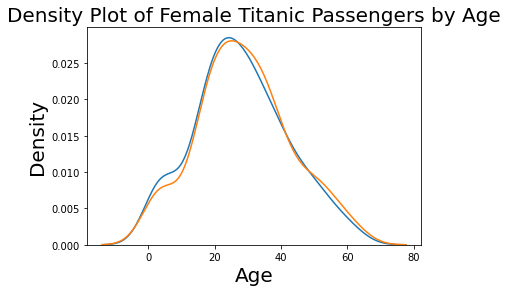

In [20]:
print(females["Survived"].value_counts())

sns.kdeplot(females['Age'], label = 'all females', shade = False, alpha = 0.8)
sns.kdeplot(survived_females['Age'], label = 'survived females', shade = False, alpha = 0.8)

# label the plot
plt.xlabel('Age', size = 20)
plt.ylabel('Density', size = 20)
plt.title('Density Plot of Female Titanic Passengers by Age', size = 20)

0    468
1    109
Name: Survived, dtype: int64


Text(0.5, 1.0, 'Density Plot of Male Titanic Passengers by Age')

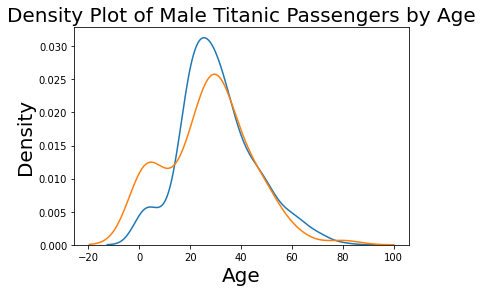

In [21]:
print(males["Survived"].value_counts())

sns.kdeplot(males['Age'], label = 'all males', shade = False, alpha = 0.8)
sns.kdeplot(survived_males['Age'], label = 'survived males', shade = False, alpha = 0.8)

# label the plot
plt.xlabel('Age', size = 20); plt.ylabel('Density', size = 20)
plt.title('Density Plot of Male Titanic Passengers by Age', size = 20)

#### Survived by Pclass

In [22]:
df_train.groupby('Pclass').Survived.value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [23]:
df_train.groupby(['Pclass']).Survived.value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [24]:
df_by_class = df_train.groupby('Pclass')
df_by_class.describe()

PassengerId                                                             \
             count        mean         std   min     25%    50%    75%    max   
Pclass                                                                          
1            216.0  461.597222  246.737616   2.0  270.75  472.0  670.5  890.0   
2            184.0  445.956522  250.852161  10.0  234.50  435.5  668.0  887.0   
3            491.0  439.154786  264.441453   1.0  200.00  432.0  666.5  891.0   

       Survived            ... Parch        Fare                             \
          count      mean  ...   75%  max  count       mean        std  min   
Pclass                     ...                                                
1         216.0  0.629630  ...   0.0  4.0  216.0  84.154687  78.380373  0.0   
2         184.0  0.472826  ...   1.0  3.0  184.0  20.662183  13.417399  0.0   
3         491.0  0.242363  ...   0.0  6.0  491.0  13.675550  11.778142  0.0   

                                           
             25%      50%   75%       max  
Pclass                                     
1       30.92395  60.2875  93.5  512.3292  
2       13.00000  14.2500  26.0   73.5000  
3        7.75000   8.0500  15.5   69.5500  

[3 rows x 48 columns]

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

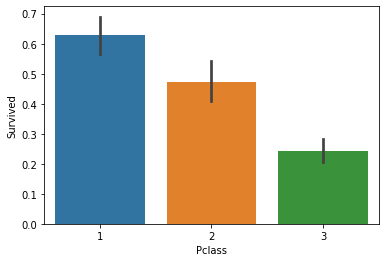

In [25]:
sns.barplot(x='Pclass', y='Survived', data=df_train)

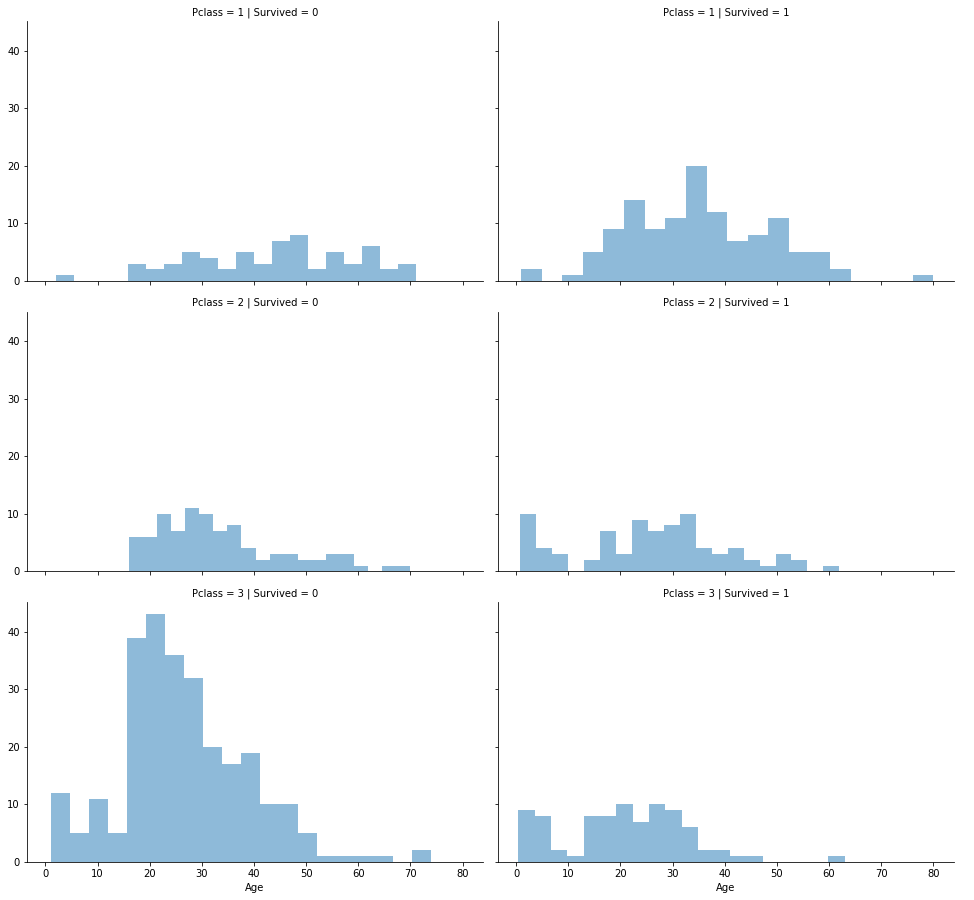

In [26]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', height=4.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

#### Survived by Age

<AxesSubplot:>

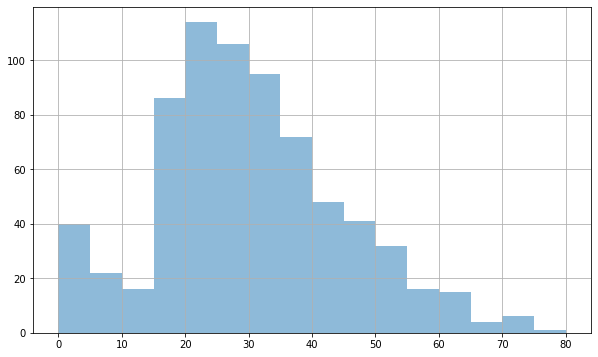

In [27]:
#df_train['Age'].hist()
df_train['Age'].dropna().hist(bins=16, range=(0,80), alpha = .5, figsize=(10,6))

In [28]:
ser, bins = pd.qcut(df_train.Age.dropna(), 5, retbins=True, labels=False)
print(bins)
df_train.groupby(ser).Survived.value_counts()

[ 0.42 19.   25.   31.8  41.   80.  ]


Age  Survived
0.0  0           85
     1           79
1.0  0           92
     1           45
2.0  0           77
     1           50
3.0  0           81
     1           63
4.0  0           89
     1           53
Name: Survived, dtype: int64

#### Sex and Pclass

In [29]:
df_train.groupby(['Pclass']).Sex.value_counts()

Pclass  Sex   
1       male      122
        female     94
2       male      108
        female     76
3       male      347
        female    144
Name: Sex, dtype: int64

In [30]:
df_train.groupby(['Pclass','Sex']).Survived.value_counts()

Pclass  Sex     Survived
1       female  1            91
                0             3
        male    0            77
                1            45
2       female  1            70
                0             6
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Survived, dtype: int64

In [31]:
id = pd.crosstab([df_train.Pclass, df_train.Sex], df_train.Survived.astype(float))
id.columns = (['No', 'Yes'])
id.columns.name = "Survived"
id.div(id.sum(1).astype(float), 0)

Survived             No       Yes
Pclass Sex                       
1      female  0.031915  0.968085
       male    0.631148  0.368852
2      female  0.078947  0.921053
       male    0.842593  0.157407
3      female  0.500000  0.500000
       male    0.864553  0.135447

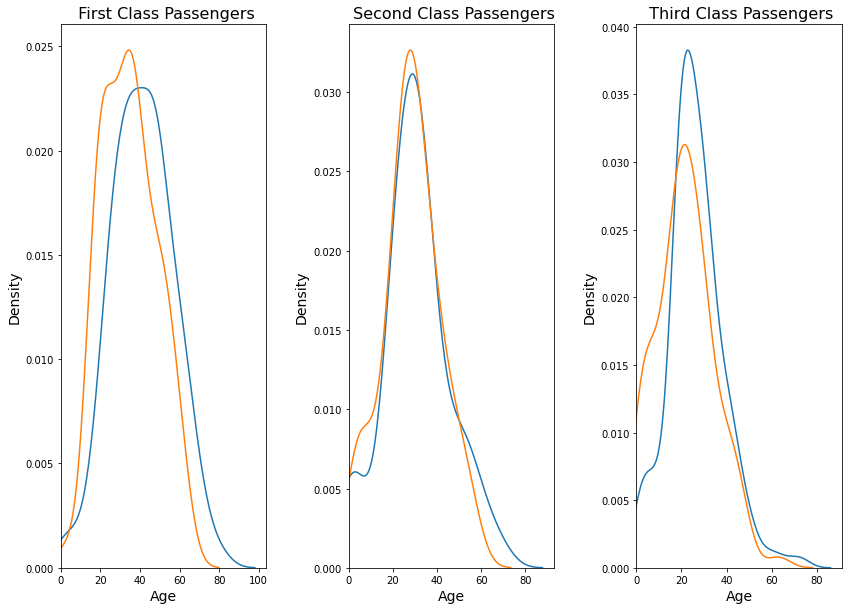

In [32]:
# Set-up 3x2 grid for plotting.

fig, sub = plt.subplots(1,3, figsize=(14,10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

titles = [" First Class "," Second Class "," Third Class "]

for i, title, ax in zip([1,2,3], titles, sub.flatten()):
    male_data = males[males['Pclass']==i]
    female_data = females[females['Pclass']==i]
    
    plt_title = title + 'Passengers'
    sns.kdeplot(male_data['Age'],
               label = 'male', shade = False, alpha = 0.8,ax=ax);
    sns.kdeplot(female_data['Age'],
               label = 'female', shade = False, alpha = 0.8, ax=ax)
    
    ax.set_xlabel('Age', size = 14)
    ax.set_ylabel('Density', size = 14)
    ax.set_title(plt_title, size = 16)
    ax.set(xlim=(0))
    
plt.show()

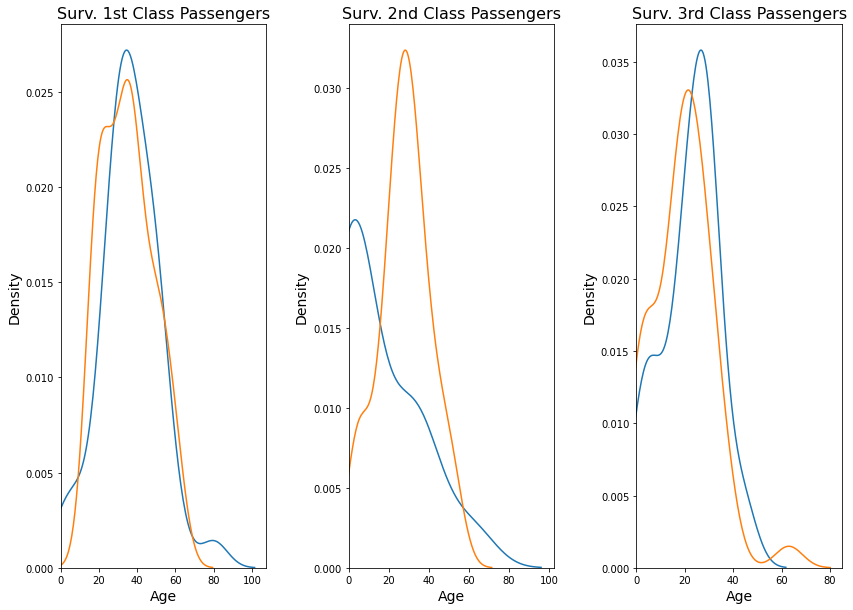

In [33]:
# Set-up 3x2 grid for plotting.

fig, sub = plt.subplots(1,3, figsize=(14,10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

titles = [" 1st Class "," 2nd Class "," 3rd Class "]

for i, title, ax in zip([1,2,3], titles, sub.flatten()):
    male_data = survived_males[survived_males['Pclass']==i]
    female_data = survived_females[survived_females['Pclass']==i]
    
    plt_title = 'Surv.'+ title + 'Passengers'
    sns.kdeplot(male_data['Age'], label='male', shade=False, alpha=0.8,ax=ax);
    ax.set_xlabel('Age', size=14)
    
    sns.kdeplot(female_data['Age'], label='female', shade=False, alpha=0.8, ax=ax)
    ax.set_xlabel('Age', size=14)
    
    ax.set_ylabel('Density', size=14)
    ax.set_title(plt_title, size=16)
    ax.set(xlim=(0))
    
plt.show()

### Dealing with missing values

In [34]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent_1 = df_train.isnull().sum()/df_train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


#### Encoding the "Sex" field

In [35]:
df_train['Gender'] = df_train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
df_test['Gender'] = df_test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

#### Filling the null values for Age

In [36]:
print(len(df_train[df_train['Age'].isnull()]))
print(len(df_test[df_test['Age'].isnull()]))

177
86


In [37]:
df_train['AgeFill'] = df_train['Age']
df_test['AgeFill'] = df_test['Age']

In [38]:
df_train[df_train['Age'].isnull()][['Gender','Pclass','Age','AgeFill']].head(4)

,Gender,Pclass,Age,AgeFill
5,1,3,NaN,NaN
17,1,2,NaN,NaN
19,0,3,NaN,NaN
26,1,3,NaN,NaN


In [39]:
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df_train[(df_train['Gender'] == i) & (df_train['Pclass'] == j+1)]['Age'].dropna().median()

median_ages

array([[35. , 28. , 21.5],
       [40. , 30. , 25. ]])

In [40]:
for i in range(0, 2):
    for j in range(0, 3):
        df_train.loc[(df_train.Age.isnull()) & (df_train.Gender == i) & (df_train.Pclass == j+1),'AgeFill'] = median_ages[i,j]
        df_test.loc[(df_test.Age.isnull()) & (df_test.Gender == i) & (df_test.Pclass == j+1),'AgeFill'] = median_ages[i,j]

In [41]:
df_train[df_train['Age'].isnull()][['Gender','Pclass','Age','AgeFill']].head(4)

,Gender,Pclass,Age,AgeFill
5,1,3,NaN,25.0
17,1,2,NaN,30.0
19,0,3,NaN,21.5
26,1,3,NaN,25.0


#### Filling the null values for "Embarked"

In [42]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,38.0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,62.0


In [43]:
df_train[59:64]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,1,11.0
60,61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C,1,22.0
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN,0,38.0
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S,1,45.0
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,1,4.0


In [44]:
df_train[826:832]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,1,25.00
827,828,1,2,"Mallet, Master. Andre",male,1.00,0,2,S.C./PARIS 2079,37.0042,NaN,C,1,1.00
828,829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,1,25.00
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.00,0,0,113572,80.0000,B28,NaN,0,62.00
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.00,1,0,2659,14.4542,NaN,C,0,15.00
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S,1,0.83


#### Associating the missing values to the most likely class

In [45]:
df_train['Embarked'] = df_train['Embarked'].map({np.nan:1,'C':1, 'Q':2,'S':3} ).astype(int)
df_test['Embarked'] = df_test['Embarked'].map({np.nan:1,'C':1, 'Q':2,'S':3} ).astype(int)

#### One-Hot-Enconding the field "Embarked"

In [46]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

In [47]:
df_train.groupby(['Embarked']).Survived.value_counts()

Embarked  Survived
1         1            95
          0            75
2         0            47
          1            30
3         0           427
          1           217
Name: Survived, dtype: int64

In [48]:
df_train.groupby(['Embarked']).Fare.mean()

Embarked
1    60.189978
2    13.276030
3    27.079812
Name: Fare, dtype: float64

In [49]:
embarked = pd.DataFrame(lb.fit_transform(df_train['Embarked'].values), columns=['Emb1','Emb2','Emb3'])
df_train = pd.concat([df_train, embarked], axis=1)

In [50]:
embarked = pd.DataFrame(lb.fit_transform(df_test['Embarked'].values), columns=['Emb1','Emb2','Emb3'])
df_test = pd.concat([df_test, embarked], axis=1)

#### One-Hot-Enconding the field "Cabin"

In [51]:
df_train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
F2             3
D              3
              ..
B41            1
D7             1
D45            1
D19            1
D37            1
Name: Cabin, Length: 147, dtype: int64

In [52]:
CabinTrans = pd.DataFrame(mlb.fit_transform([{str(val)} for val in df_train['Cabin'].values]))

In [53]:
CabinTrans.head()

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [54]:
#df_train = pd.concat([df_train, CabinTrans], axis=1)

Instead of using the Cabin feature as it is - using traditional hot-encoding, we can try using only the letters.  
After doing some research, we could know that a cabin number looks like ‘C123’ and the letter refers to the deck.  
+ We’re going to extract these and create a new feature, that contains a persons deck.  
+ And then we will convert the feature into a numeric variable.

In [55]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [df_train, df_test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

In [56]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill,Emb1,Emb2,Emb3,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,3,1,22.0,0,0,1,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,0,38.0,1,0,0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U0,3,0,26.0,0,0,1,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,3,0,35.0,0,0,1,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U0,3,1,35.0,0,0,1,8


#### Creating a feature for number of relatives

In [57]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_train['Age*Class'] = df_train.AgeFill * df_train.Pclass

df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']
df_test['Age*Class'] = df_test.AgeFill * df_test.Pclass

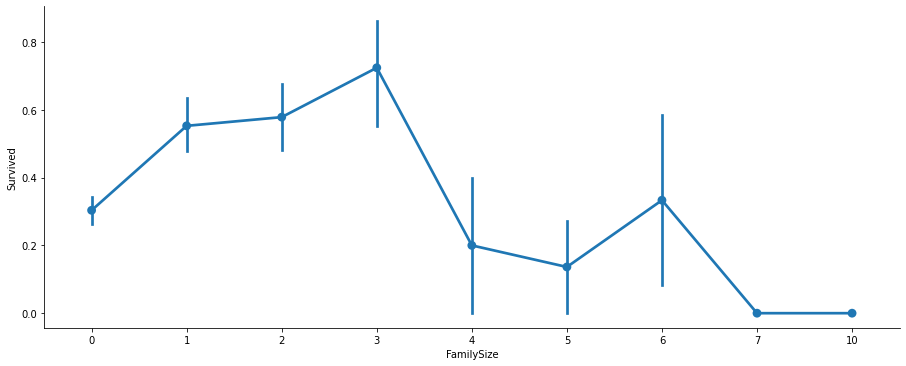

In [58]:
axes = sns.catplot(x='FamilySize', y='Survived', kind='point' , data=df_train, aspect = 2.5, )

#### Extract the Titles from "Name", so that we can build a new feature out of that. (TBD)

In [59]:
#data = [df_train, df_test]
#titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

#for dataset in data:
#    # extract titles
#    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
#    # replace titles with a more common title or as Rare
#    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
#                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
#    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
#    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
#    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
#    # convert titles into numbers
#    dataset['Title'] = dataset['Title'].map(titles)
#    # filling NaN with 0, to get safe
#    dataset['Title'] = dataset['Title'].fillna(0)

#### Fare per Person (TBD)

In [60]:
#for dataset in data:
#    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['FamilySize']+1)
#    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

#df_train.head(10)

### Exploring "Ticket"

In [61]:
df_train['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

Since the Ticket attribute has 681 unique tickets, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

### Discarding unused columns for predictions

In [62]:
df_train2 = df_train.drop(['Age','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df_train2 = df_train2.dropna()

df_test2 = df_test.drop(['Age','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df_test2 = df_test2.dropna()

In [63]:
df_train2.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Gender,AgeFill,Emb1,Emb2,Emb3,Deck,FamilySize,Age*Class
0,1,0,3,1,0,7.2500,1,22.0,0,0,1,8,1,66.0
1,2,1,1,1,0,71.2833,0,38.0,1,0,0,3,1,38.0
2,3,1,3,0,0,7.9250,0,26.0,0,0,1,8,0,78.0
3,4,1,1,1,0,53.1000,0,35.0,0,0,1,3,1,35.0
4,5,0,3,0,0,8.0500,1,35.0,0,0,1,8,0,105.0


In [64]:
df_test2.head()

,PassengerId,Pclass,SibSp,Parch,Fare,Gender,AgeFill,Emb1,Emb2,Emb3,Deck,FamilySize,Age*Class
0,892,3,0,0,7.8292,1,34.5,0,1,0,8,0,103.5
1,893,3,1,0,7.0000,0,47.0,0,0,1,8,1,141.0
2,894,2,0,0,9.6875,1,62.0,0,1,0,8,0,124.0
3,895,3,0,0,8.6625,1,27.0,0,0,1,8,0,81.0
4,896,3,1,1,12.2875,0,22.0,0,0,1,8,2,66.0


### Running some correlation hypothesis:

In [65]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
## https://github.com/statsmodels/statsmodels/issues/3931 waiting for fixes

y = df_train2.Survived
X = df_train2.Gender
model = sm.Logit(y, X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.558118
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            0
Date:                Thu, 14 Oct 2021   Pseudo R-squ.:                  0.1619
Time:                        19:33:59   Log-Likelihood:                -497.28
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Gender        -1.4571      0.106    -13.701      0.000      -1.666      -1.249


In [66]:
y = df_train2.Survived
X = df_train2[['Gender','Pclass','AgeFill']]
model = sm.Logit(y, X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.529672
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      888
Method:                           MLE   Df Model:                            2
Date:                Thu, 14 Oct 2021   Pseudo R-squ.:                  0.2046
Time:                        19:34:00   Log-Likelihood:                -471.94
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.910e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Gender        -2.1764      0.170    -12.829      0.000      -2.509      -1.844
Pclass        -0.0671      0.

### Preparing Data for predictions

#### Renaming target class (For the TPOT genetic algorithm) 

In [67]:
df_train2.rename(columns={'Survived': 'class'}, inplace=True)
df_train2.head(3)

,PassengerId,class,Pclass,SibSp,Parch,Fare,Gender,AgeFill,Emb1,Emb2,Emb3,Deck,FamilySize,Age*Class
0,1,0,3,1,0,7.2500,1,22.0,0,0,1,8,1,66.0
1,2,1,1,1,0,71.2833,0,38.0,1,0,0,3,1,38.0
2,3,1,3,0,0,7.9250,0,26.0,0,0,1,8,0,78.0


In [68]:
df_test2.head(3)

,PassengerId,Pclass,SibSp,Parch,Fare,Gender,AgeFill,Emb1,Emb2,Emb3,Deck,FamilySize,Age*Class
0,892,3,0,0,7.8292,1,34.5,0,1,0,8,0,103.5
1,893,3,1,0,7.0000,0,47.0,0,0,1,8,1,141.0
2,894,2,0,0,9.6875,1,62.0,0,1,0,8,0,124.0


### Creating Numpy vectors and adjusting features scales:   

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_train2.iloc[:,2:] = scaler.fit_transform(df_train2.iloc[:,2:])  #Excludes PassengerId and class
df_test2.iloc[:,1:] = scaler.fit_transform(df_test2.iloc[:,1:])  #Excludes PassengerId

In [70]:
X = df_train2.iloc[:,2:].values
y = df_train2.iloc[:,1].values
X_val = df_test2.iloc[:,1:].values

In [71]:
print(X.shape)
print(y.shape)
print(X_val.shape)

(891, 12)
(891,)
(417, 12)


### Creating cross-validation subsets:  

http://scikit-learn.org/stable/modules/cross_validation.html  
http://www.analyticsvidhya.com/blog/2015/05/k-fold-cross-validation-simple/  
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html  
http://stackoverflow.com/questions/25375203/identical-learning-curves-on-subsequent-runs-using-shufflesplit  
http://stackoverflow.com/questions/28064634/random-state-pseudo-random-numberin-scikit-learn  

In [72]:
from sklearn import model_selection

## Creating validation set with cross validation
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

## Using stratified k-folds
#skf = model_selection.StratifiedKFold(n_splits=1)
#skf.get_n_splits(X, y)

cv = model_selection.StratifiedKFold(n_splits=5)


def mean_scores_cv(clf, cv, X, y):
    scores = model_selection.cross_val_score(clf, X, y, 
                                              scoring=None, 
                                              cv=cv, 
                                              n_jobs=1,
                                              verbose=0,
                                              fit_params=None,
                                              pre_dispatch='2*n_jobs')
    return scores.mean()

In [73]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(623, 12)
(623,)
(268, 12)
(268,)


### Balancing the classes

In [74]:
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))

381
242


#### Oversampling the minority class  
http://contrib.scikit-learn.org/imbalanced-learn/  

In [75]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

X_train, y_train = smote.fit_resample(X_train, y_train)

In [76]:
print(X_train.shape)
print(y_train.shape)
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))

(762, 12)
(762,)
381
381


### Importing modules for evaluation of the models

http://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat   
http://scikit-learn.org/stable/modules/cross_validation.html  

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

### Creating functions to help evaluate the models

In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(clf, X, y_true, classes=['Perished', 'Survived']):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

## Testing classifiers of different families:  

### Linear Classifiers

A linear classifier achieves this by making a classification decision based on the value of a linear combination of the characteristics. An object's characteristics are also known as feature values and are typically presented to the machine in a vector called a feature vector. Such classifiers work well for practical problems such as document classification, and more generally for problems with many variables (features), reaching accuracy levels comparable to non-linear classifiers while taking less time to train and use.

#### [Support Vector Machines](https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/)  

Support vector machines (SVMs, also support vector networks) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

An SVM will find a hyperplane or a boundary between the two classes of data that maximizes. There are other planes as well which can separate the two classes, but only the SVM hyperplane can maximize the margin between the classes.

B0 + (B1 * X1) + (B2 * X2) = 0 where, B1 and B2 determines the slope of the line and B0 (intercept) found by the learning algorithm. X1 and X2 are the two input variables.

![SVM](../Data/Figs/SVM.jpeg)

#### Choosing the best parameters using [GridSearchCV](http://scikit-learn.org/stable/modules/grid_search.html) or [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)  
  

In [79]:
%%time

#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn import svm

estimator = svm.SVC()

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
Cs = np.linspace(0.1,3,7)
degrees = [2,3,4,5]
gammas = np.logspace(-5, 0, 7)

param_grid=dict(kernel=kernels, C=Cs, gamma=gammas, degree=degrees)

## Grid Search (more exhaustive)
#clf_svc = model_selection.GridSearchCV(estimator=estimator,
#                                       cv=cv,
#                                       param_grid=param_grid, 
#                                       n_jobs=-1).fit(X_train, y_train)

## Randomized (faster)
clf_svc = model_selection.RandomizedSearchCV(estimator=estimator,
                                             cv=cv,
                                             param_distributions=param_grid, 
                                             n_jobs=-1).fit(X_train, y_train)


with open(os.path.join(outputs,'best_parameters_svm.pickle'), 'wb') as f:
    pickle.dump(clf_svc,f)

with open(os.path.join(outputs,'best_parameters_svm.pickle'), 'rb') as f:
    clf_svc = pickle.load(f)

print(clf_svc.best_score_)
print(clf_svc.best_estimator_.kernel)
print(clf_svc.best_estimator_.C)
print(clf_svc.best_estimator_.degree)
print(clf_svc.best_estimator_.gamma)

0.8071293429652563
rbf
2.5166666666666666
2
0.14677992676220705
CPU times: user 168 ms, sys: 276 ms, total: 444 ms
Wall time: 2.46 s


#### Now, let's run with the best hiperparameters

Classification Report
              precision    recall  f1-score   support

    Perished       0.84      0.82      0.83       168
    Survived       0.71      0.74      0.73       100

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

ROC Score: 0.7807142857142857
Accuracy Score: 0.7910447761194029
Average Precision Score: 0.6235533869115959
f1 Score: 0.7254901960784313
Confusion matrix, without normalization
[[138  30]
 [ 26  74]]
CPU times: user 157 ms, sys: 10.8 ms, total: 168 ms
Wall time: 161 ms


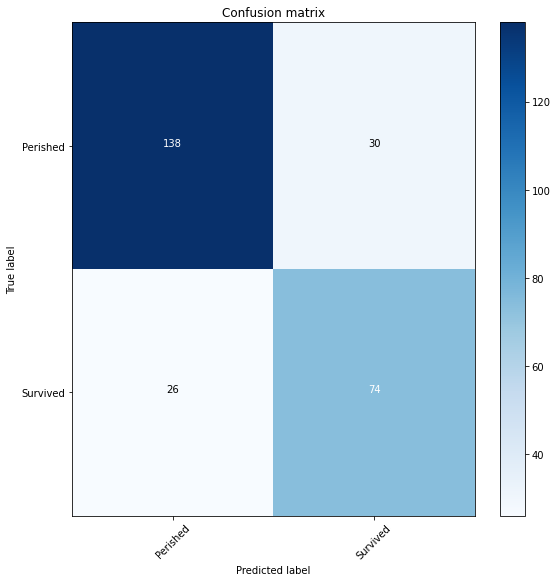

In [80]:
%%time

clf_svc2 = svm.SVC(kernel=clf_svc.best_estimator_.kernel,
                   C=clf_svc.best_estimator_.C,
                   degree=clf_svc.best_estimator_.degree, 
                   gamma=clf_svc.best_estimator_.gamma, 
                   coef0=0.0, 
                   shrinking=True, 
                   probability=False, 
                   tol=0.001, 
                   cache_size=200, 
                   class_weight=None, 
                   verbose=False, 
                   max_iter=-1, 
                   random_state=0).fit(X_train, y_train)

roc_svc2 = clf_eval(clf_svc2, X_test, y_test)

#### For this first classifier, we'll also display the [learning curve](http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.learning_curve.html)  

In [81]:
%%time

def plot_learning_curve(estimator, 
                        title, 
                        X, 
                        y, 
                        ylim=None, 
                        cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator, 
                                                            X, y, cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 189 µs, sys: 0 ns, total: 189 µs
Wall time: 190 µs


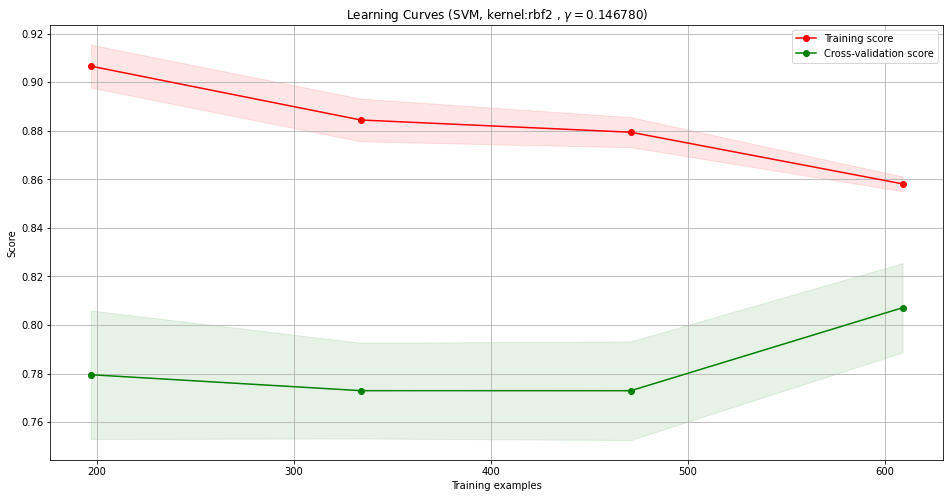

In [82]:
title = 'Learning Curves (SVM, kernel:{1}{0} , $\gamma={2:.6f}$)'.format(clf_svc.best_estimator_.degree,
                                                                         clf_svc.best_estimator_.kernel,
                                                                         clf_svc.best_estimator_.gamma)
graph = plot_learning_curve(clf_svc2, title, X_train, y_train, cv=cv)
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')
graph.show()

#### [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  

Logistic regression is a classification algorithm based on the function which is used at the core of the method, logistic function or sigmoid function. It’s an S-shaped curve that is used to predict a binary outcome (1/0, Yes/No, True/False) given a set of independent variables.

+ It can also be thought of as a special case of linear regression when the outcome variable is categorical, where we are using the log of odds as a dependent variable.
+ It predicts the probability of occurrence of an event by fitting data to a logit function.

p(X) = e^(b0 + b1*X) / (1 + e^(b0 + b1*X))

Logistic regression, or logit regression, or logit model is a regression model where the dependent variable (DV) is categorical. In the binary case, a dependent variable (the output) can take only two values, "0" and "1", which represent outcomes such as pass/fail, win/lose, alive/dead or healthy/sick. Cases where the dependent variable has more than two outcome categories may be analysed in multinomial logistic regression, or, if the multiple categories are ordered, in ordinal logistic regression.


![Logistic](../Data/Figs/logistic.jpeg)

Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.80      0.84       168
    Survived       0.71      0.80      0.75       100

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.81      0.80      0.80       268

ROC Score: 0.8017857142857143
Accuracy Score: 0.8022388059701493
Average Precision Score: 0.640998547087571
f1 Score: 0.7511737089201878
Confusion matrix, without normalization
[[135  33]
 [ 20  80]]
CPU times: user 120 ms, sys: 6.67 ms, total: 127 ms
Wall time: 161 ms


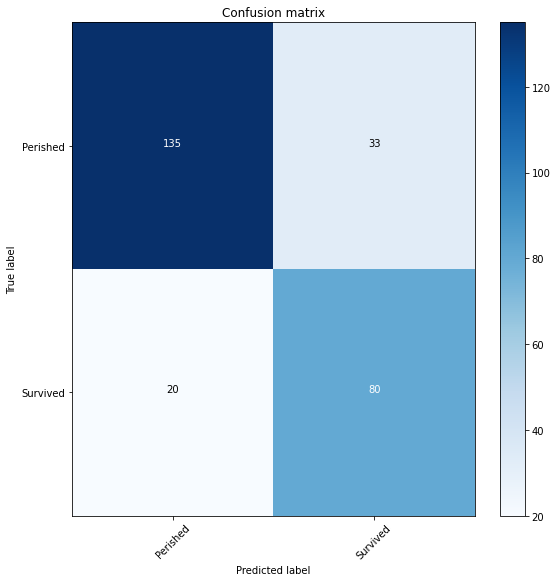

In [83]:
%%time

from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            dual=False, 
                            tol=0.001, 
                            C=0.10, 
                            fit_intercept=True, 
                            intercept_scaling=1, 
                            class_weight=None, 
                            random_state=0, 
                            solver='saga', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=-1).fit(X_train, y_train)

roc_lr = clf_eval(clf_lr, X_test, y_test)

#### Assessing the importance of the features

Gender       -1.116801
Pclass       -0.440321
Age*Class    -0.387284
SibSp        -0.344201
AgeFill      -0.274650
FamilySize   -0.207666
Deck         -0.109161
Emb3         -0.046679
Emb2         -0.017754
Fare          0.033444
Parch         0.055213
Emb1          0.065872
dtype: float64


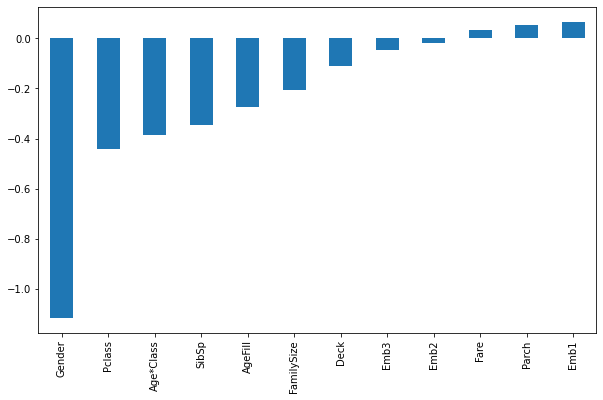

In [84]:
coefs = pd.Series(clf_lr.coef_[0], index=df_train2.iloc[:,2:].columns)
coefs = coefs.sort_values()
coefs.plot(kind="bar", figsize=(10,6))
print(coefs.sort_values(ascending = True))

#### Precision Recall Curve

For each person the classifier algorithm has to classify, it computes a probability based on a function and it classifies the person as survived (when the score is bigger the than threshold) or as not survived (when the score is smaller than the threshold). That’s why the threshold plays an important part.

We will plot the precision and recall with the threshold using matplotlib:

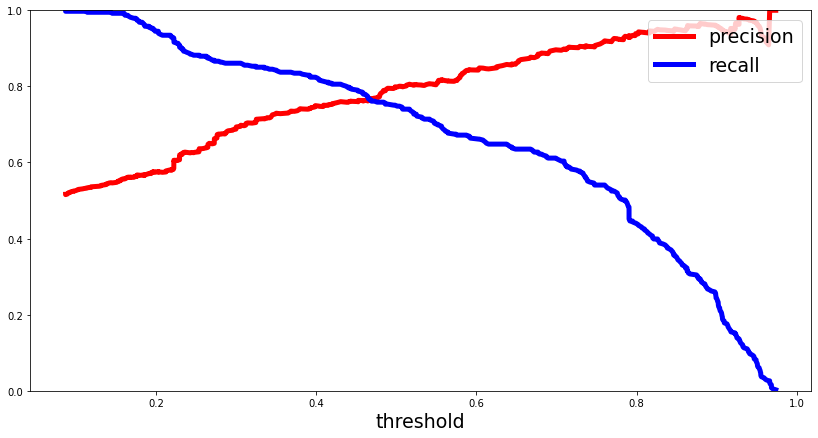

In [85]:
# getting the probabilities of our predictions
y_scores = clf_lr.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Another way is to plot the precision and recall against each other:

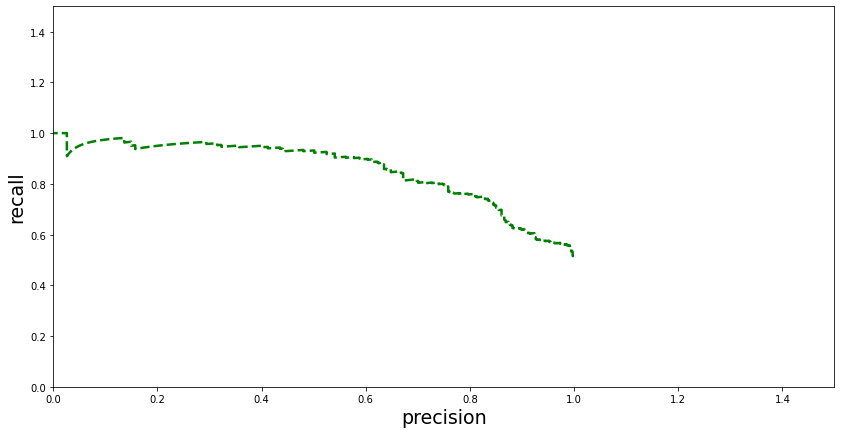

In [86]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

#### [Ridge Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)  

Ridge Classifiers addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients. The ridge coefficients minimize a penalized residual sum of squares

/home/rsouza/environments/default_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Classification Report
              precision    recall  f1-score   support

    Perished       0.85      0.80      0.83       168
    Survived       0.70      0.76      0.73       100

    accuracy                           0.79       268
   macro avg       0.77      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

ROC Score: 0.7817857142857143
Accuracy Score: 0.7873134328358209
Average Precision Score: 0.6194604956867041
f1 Score: 0.7272727272727273
Confusion matrix, without normalization
[[135  33]
 [ 24  76]]
CPU times: user 115 ms, sys: 7.14 ms, total: 122 ms
Wall time: 409 ms


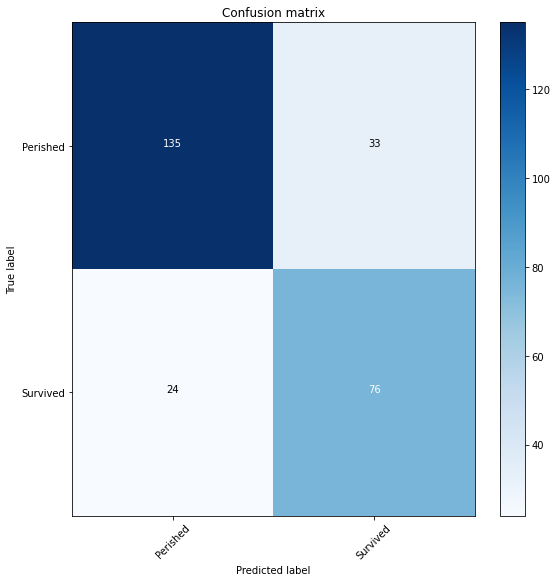

In [87]:
%%time

from sklearn.linear_model import RidgeClassifier

clf_rdg = RidgeClassifier(alpha=1.0, 
                          fit_intercept=True, 
                          normalize=False, 
                          copy_X=True, 
                          max_iter=None, 
                          tol=0.001, 
                          class_weight=None, 
                          solver='auto', 
                          random_state=0).fit(X_train, y_train)

roc_rdg = clf_eval(clf_rdg, X_test, y_test)

#### [Perceptron](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron)

Perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time.

Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.78      0.82       168
    Survived       0.68      0.78      0.73       100

    accuracy                           0.78       268
   macro avg       0.77      0.78      0.77       268
weighted avg       0.79      0.78      0.78       268

ROC Score: 0.7798809523809523
Accuracy Score: 0.7798507462686567
Average Precision Score: 0.6111330304996756
f1 Score: 0.7255813953488374
Confusion matrix, without normalization
[[131  37]
 [ 22  78]]
CPU times: user 117 ms, sys: 2.78 ms, total: 120 ms
Wall time: 181 ms


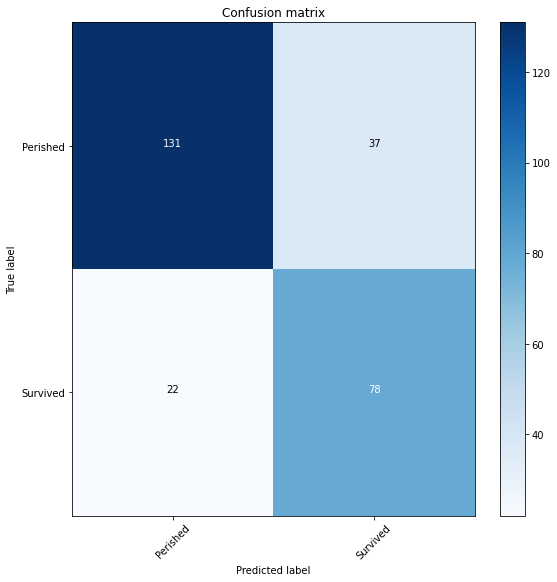

In [88]:
%%time

from sklearn.linear_model import Perceptron

clf_pcp = Perceptron(penalty=None,
                     alpha=0.001,
                     fit_intercept=True,
                     max_iter=230,
                     shuffle=True,
                     verbose=0,
                     eta0=1.0,
                     n_jobs=-1, 
                     random_state=0, 
                     class_weight=None, 
                     warm_start=False).fit(X_train, y_train)

roc_pcp = clf_eval(clf_pcp, X_test, y_test)

#### [Passive Aggressive](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html)  

https://www.bonaccorso.eu/2017/10/06/ml-algorithms-addendum-passive-aggressive-algorithms/ 

Passive Aggressive Algorithms are a family of online learning algorithms (for both classification and regression) proposed by Crammer at al. The idea is very simple and their performance has been proofed to be superior to many other alternative methods like Online Perceptron and MIRA (see the original paper in the reference section). Passive: if correct classification, keep the model; Aggressive: if incorrect classification, update to adjust to this misclassified example. In my mind, in passive, the information hidden in the example is not enough for updating; in aggressive, the information shows that at lest this time you are wrong, a better model should modify this mistake.   

Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.79      0.83       168
    Survived       0.69      0.81      0.75       100

    accuracy                           0.79       268
   macro avg       0.78      0.80      0.79       268
weighted avg       0.81      0.79      0.80       268

ROC Score: 0.7978571428571428
Accuracy Score: 0.7947761194029851
Average Precision Score: 0.6316647531572905
f1 Score: 0.7465437788018433
Confusion matrix, without normalization
[[132  36]
 [ 19  81]]
CPU times: user 113 ms, sys: 7.4 ms, total: 120 ms
Wall time: 113 ms


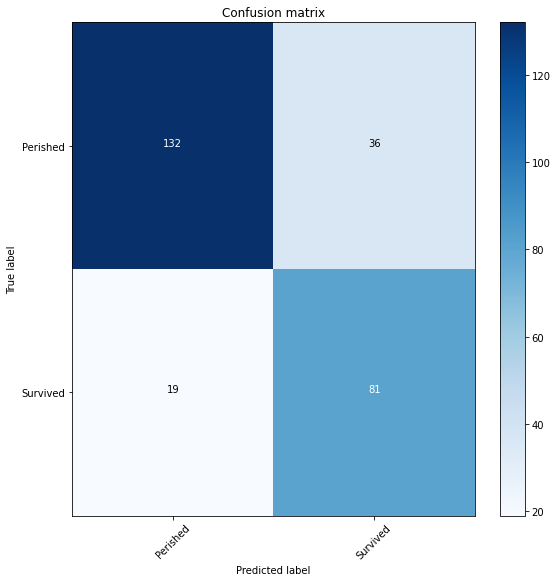

In [89]:
%%time

from sklearn.linear_model import PassiveAggressiveClassifier

clf_pac = PassiveAggressiveClassifier(C=0.1, 
                                      fit_intercept=True, 
                                      max_iter=100, 
                                      shuffle=True, 
                                      verbose=0, 
                                      loss='hinge', 
                                      n_jobs=-1, 
                                      random_state=0, 
                                      warm_start=False, 
                                      class_weight=None).fit(X_train, y_train)

roc_pac = clf_eval(clf_pac, X_test, y_test)

#### [SGDC Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)  

The SGDC classifier is a linear classifier (SVM, logistic regression) with SGD training. Implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.  

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). If the parameter update crosses the 0.0 value because of the regularizer, the update is truncated to 0.0 to allow for learning sparse models and achieve online feature selection.  

Classification Report
              precision    recall  f1-score   support

    Perished       0.77      0.72      0.74       168
    Survived       0.58      0.64      0.61       100

    accuracy                           0.69       268
   macro avg       0.67      0.68      0.68       268
weighted avg       0.70      0.69      0.69       268

ROC Score: 0.6801190476190477
Accuracy Score: 0.6902985074626866
Average Precision Score: 0.5033373672179642
f1 Score: 0.6066350710900474
Confusion matrix, without normalization
[[121  47]
 [ 36  64]]
CPU times: user 117 ms, sys: 12.2 ms, total: 129 ms
Wall time: 122 ms


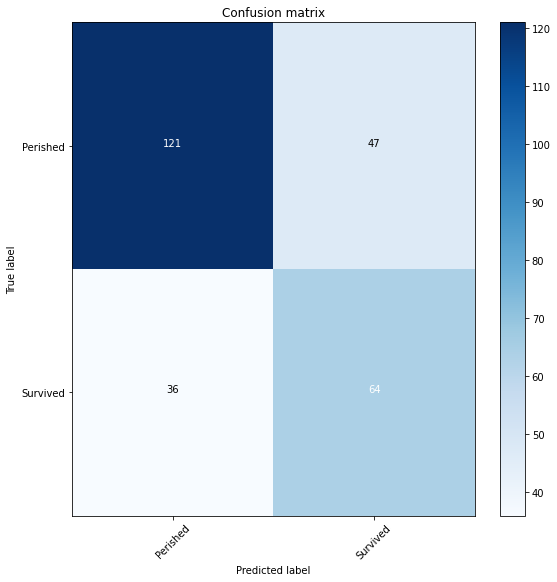

In [90]:
%%time

from sklearn.linear_model import SGDClassifier

clf_sgdc = SGDClassifier(loss='hinge',
                         penalty='l2', 
                         alpha=0.0001,
                         l1_ratio=0.15, 
                         fit_intercept=True,
                         max_iter=200, 
                         shuffle=True,
                         verbose=0,
                         epsilon=0.1,
                         n_jobs=-1,
                         random_state=0,
                         learning_rate='optimal',
                         eta0=0.0, 
                         power_t=0.5,
                         class_weight=None,
                         warm_start=False, 
                         average=False).fit(X_train, y_train)

roc_sgdc = clf_eval(clf_sgdc, X_test, y_test)

### [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)  

k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression:

+ In k-NN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

+ In k-NN regression, the output is the property value for the object. This value is the average of the values of its k nearest neighbors.

k-NN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until classification. The k-NN algorithm is among the simplest of all machine learning algorithms.

It works by finding the distances between the new data point added and the points already existed in the two separate classes. Whatever class got the highest votes, the new data point belongs to that class.

EuclideanDistance(x, xi) = sqrt( sum( (xj — xij)² ) )

![knn](../Data/Figs/knn.jpeg)

Classification Report
              precision    recall  f1-score   support

    Perished       0.90      0.82      0.86       168
    Survived       0.74      0.85      0.79       100

    accuracy                           0.83       268
   macro avg       0.82      0.84      0.83       268
weighted avg       0.84      0.83      0.83       268

ROC Score: 0.8357142857142856
Accuracy Score: 0.832089552238806
Average Precision Score: 0.6842310188189487
f1 Score: 0.7906976744186046
Confusion matrix, without normalization
[[138  30]
 [ 15  85]]
CPU times: user 179 ms, sys: 7.74 ms, total: 187 ms
Wall time: 163 ms


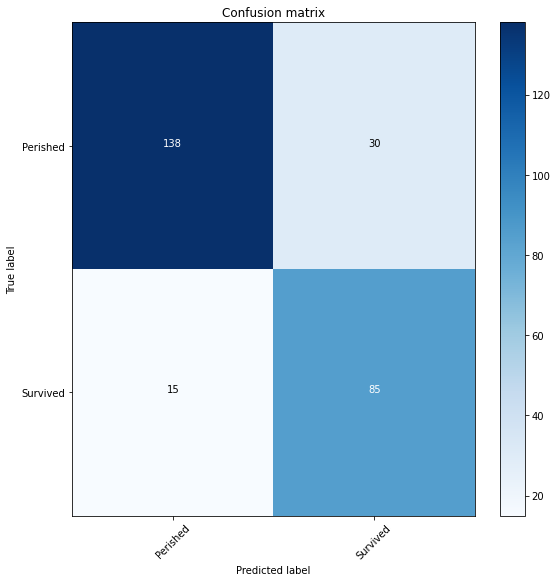

In [91]:
%%time

from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=25,
                               weights='uniform', 
                               algorithm='auto', 
                               leaf_size=30, 
                               p=4, 
                               metric='minkowski', 
                               metric_params=None, 
                               n_jobs=-1).fit(X_train, y_train)

roc_knn = clf_eval(clf_knn, X_test, y_test)

### [Decision Trees](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  

Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

Decision tree algorithms are referred to as CART or Classification and Regression Trees. It is a flowchart like a tree structure, where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (terminal node) holds a class label.

+ A Gini score gives an idea of how good a split is by how mixed the response classes are in the groups created by the split.

![dtree](../Data/Figs/dtrees.jpeg)

Classification Report
              precision    recall  f1-score   support

    Perished       0.83      0.83      0.83       168
    Survived       0.72      0.72      0.72       100

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

ROC Score: 0.7766666666666666
Accuracy Score: 0.7910447761194029
Average Precision Score: 0.6228776119402984
f1 Score: 0.72
Confusion matrix, without normalization
[[140  28]
 [ 28  72]]
CPU times: user 113 ms, sys: 7.5 ms, total: 121 ms
Wall time: 115 ms


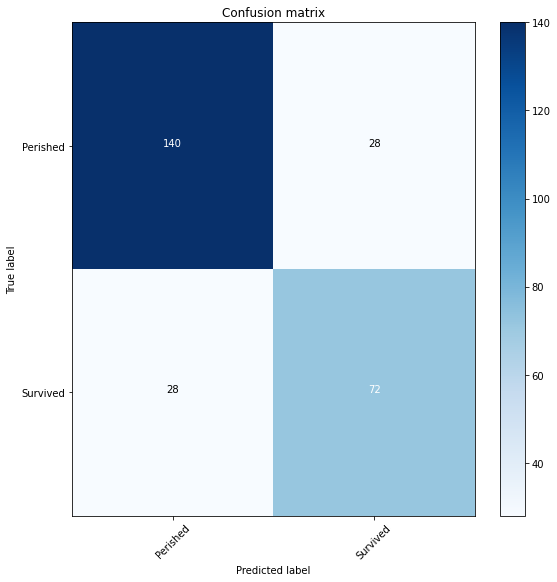

In [92]:
%%time

from sklearn.tree import DecisionTreeClassifier

clf_dtc = DecisionTreeClassifier(criterion='gini', 
                                 splitter='best', 
                                 max_depth=None, 
                                 min_samples_split=3, 
                                 min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, 
                                 max_features=None, 
                                 random_state=0, 
                                 max_leaf_nodes=None, 
                                 class_weight=None,).fit(X_train, y_train)

roc_dtc = clf_eval(clf_dtc, X_test, y_test)

### Ensemble Classifiers

A linear classifier achieves this by making a classification decision based on the value of a linear combination of the characteristics. An object's characteristics are also known as feature values and are typically presented to the machine in a vector called a feature vector. Such classifiers work well for practical problems such as document classification, and more generally for problems with many variables (features), reaching accuracy levels comparable to non-linear classifiers while taking less time to train and use.

We have many type of ensembles: 
+ Bagging
+ Boosting 
+ Voting 
+ Stacking  

### Bagging

http://scikit-learn.org/stable/modules/ensemble.html

Bootstrap aggregating, also called bagging, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Random Forests are the most common type of bagging algorithms.

#### [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

http://blog.yhathq.com/posts/random-forests-in-python.html  
http://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/  

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

+ Random forests involve creating multiple decision trees using bootstrapped datasets of the original data and randomly selecting a subset of variables at each step of the decision tree.     
+ The model then selects the mode of all of the predictions of each decision tree (bagging).

Classification Report
              precision    recall  f1-score   support

    Perished       0.85      0.84      0.85       168
    Survived       0.74      0.76      0.75       100

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

ROC Score: 0.7996428571428571
Accuracy Score: 0.8097014925373134
Average Precision Score: 0.6503289378350964
f1 Score: 0.7487684729064039
Confusion matrix, without normalization
[[141  27]
 [ 24  76]]
CPU times: user 1.05 s, sys: 233 ms, total: 1.28 s
Wall time: 1.15 s


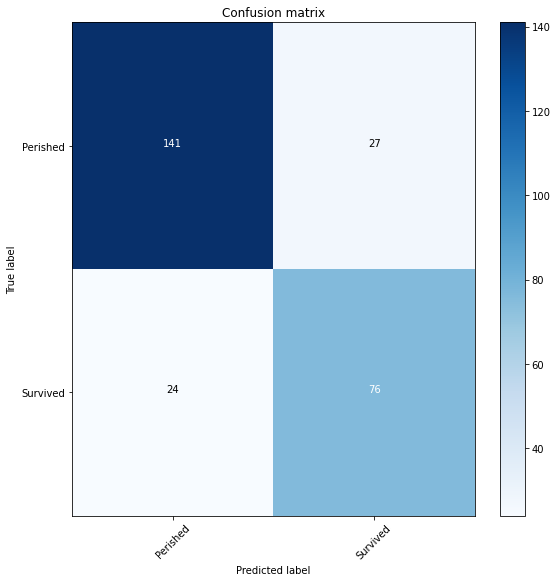

In [93]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=3, #2,
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_train, y_train)



roc_rf = clf_eval(clf_rf, X_test, y_test)

#### Assessing the importance of the features

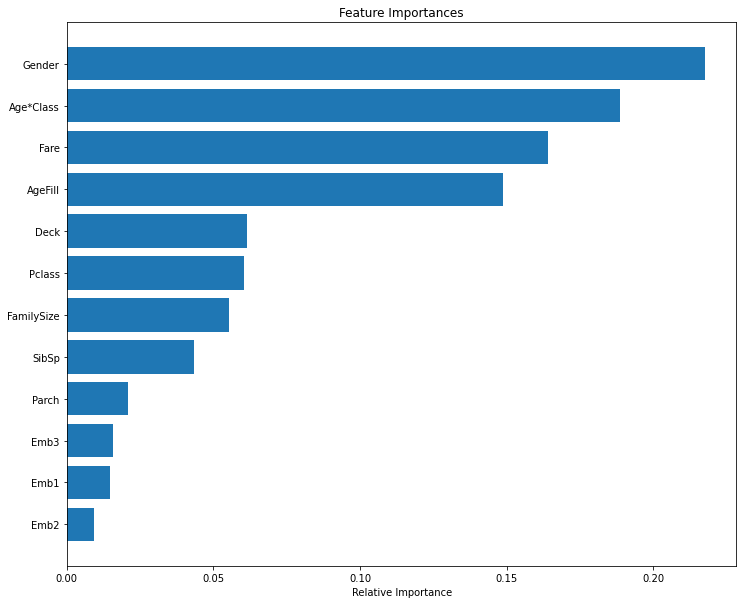

In [94]:
features = df_train2.iloc[:,2:].columns
importances = clf_rf.feature_importances_
indices = np.argsort(importances) #[0:9])  # top 10 features
plt.figure(figsize=(12,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### [Plotting the confidence intervals](https://github.com/scikit-learn-contrib/forest-confidence-interval)

Classification Report
              precision    recall  f1-score   support

    Perished       0.82      0.87      0.84       168
    Survived       0.76      0.68      0.72       100

    accuracy                           0.80       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.80      0.80      0.80       268

ROC Score: 0.7745238095238096
Accuracy Score: 0.7985074626865671
Average Precision Score: 0.6331807628524047
f1 Score: 0.7157894736842104
Confusion matrix, without normalization
[[146  22]
 [ 32  68]]
CPU times: user 153 ms, sys: 3.39 ms, total: 156 ms
Wall time: 156 ms


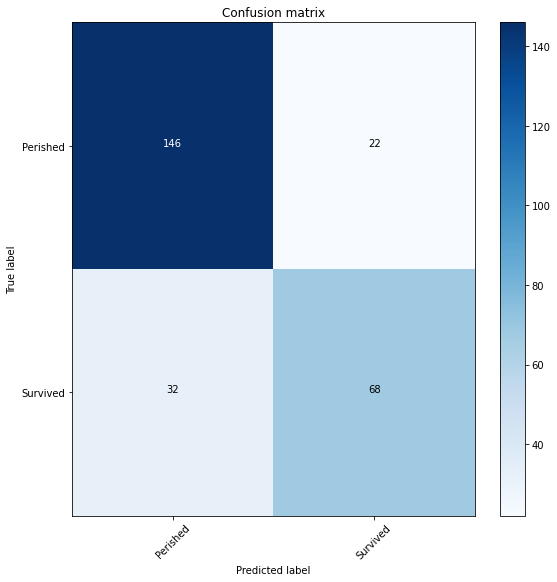

In [95]:
%%time

from sklearn.ensemble import BaggingClassifier

clf_bgc = BaggingClassifier().fit(X_train, y_train)

roc_bgc = clf_eval(clf_bgc, X_test, y_test)

#### [Extra Trees Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)  

Classification Report
              precision    recall  f1-score   support

    Perished       0.84      0.83      0.84       168
    Survived       0.73      0.74      0.73       100

    accuracy                           0.80       268
   macro avg       0.78      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

ROC Score: 0.7866666666666666
Accuracy Score: 0.7985074626865671
Average Precision Score: 0.6338776704711735
f1 Score: 0.7326732673267328
Confusion matrix, without normalization
[[140  28]
 [ 26  74]]
CPU times: user 749 ms, sys: 4.48 ms, total: 754 ms
Wall time: 749 ms


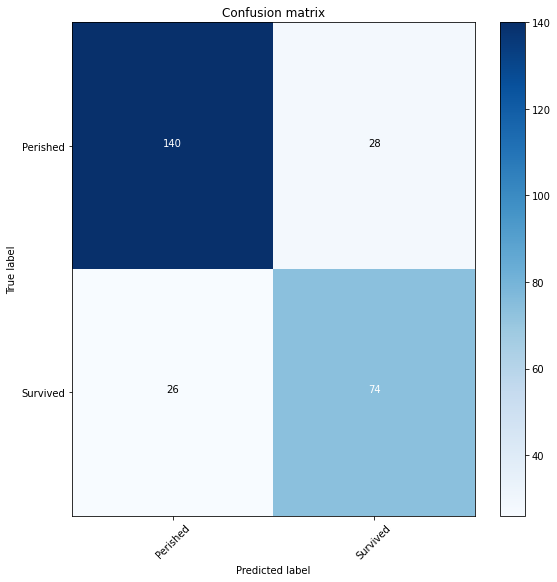

In [96]:
%%time

from sklearn.ensemble import ExtraTreesClassifier

clf_etc = ExtraTreesClassifier(n_estimators=300,
                               max_depth=None,
                               min_samples_split=3,
                               random_state=0).fit(X_train, y_train)

roc_etc = clf_eval(clf_etc, X_test, y_test)

### Boosting

Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones. Boosting is based on the question posed by Kearns and Valiant (1988, 1989): Can a set of weak learners create a single strong learner? A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing). In contrast, a strong learner is a classifier that is arbitrarily well-correlated with the true classification.


#### [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Adaptive boost is also an ensemble algorithm that leverages bagging and boosting methods to develop an enhanced predictor.

+ AdaBoost creates a forest of stumps rather than trees. A stump is a tree that is made of only one node and two leaves.
+ AdaBoost takes a more iterative approach in the sense that it seeks to iteratively improve from the mistakes that the previous stump(s) made.

Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.85      0.85       168
    Survived       0.75      0.76      0.76       100

    accuracy                           0.82       268
   macro avg       0.80      0.81      0.80       268
weighted avg       0.82      0.82      0.82       268

ROC Score: 0.8055952380952381
Accuracy Score: 0.8171641791044776
Average Precision Score: 0.6614334269247821
f1 Score: 0.7562189054726369
Confusion matrix, without normalization
[[143  25]
 [ 24  76]]
CPU times: user 942 ms, sys: 1.12 ms, total: 943 ms
Wall time: 939 ms


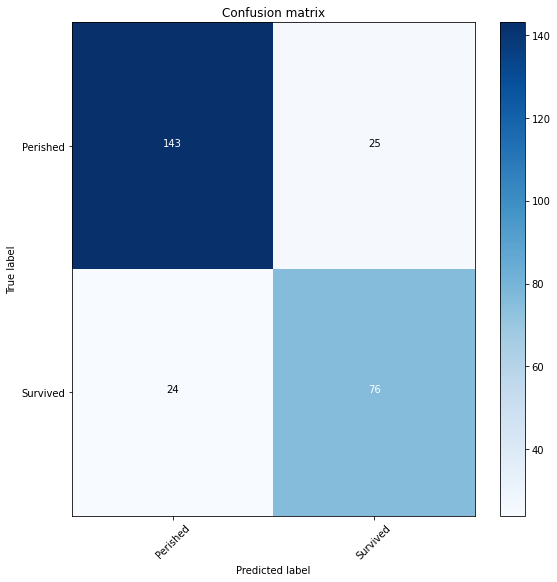

In [97]:
%%time

from sklearn.ensemble import AdaBoostClassifier

clf_abc = AdaBoostClassifier(base_estimator=None,
                             n_estimators=300,
                             learning_rate=0.1,
                             algorithm='SAMME.R',
                             random_state=0).fit(X_train, y_train)

roc_abc = clf_eval(clf_abc, X_test, y_test)

#### [Gradient Boost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html):  

Gradient Boost is also an ensemble algorithm that uses boosting methods to develop an enhanced predictor.

+ Unlike AdaBoost which builds stumps, Gradient Boost builds trees with usually 8–32 leaves.
+ Gradient Boost views the boosting problem as an optimization problem, where it uses a loss function and tries to minimize the error. This is why it’s called Gradient boost, as it’s inspired by gradient descent.

Classification Report
              precision    recall  f1-score   support

    Perished       0.85      0.85      0.85       168
    Survived       0.74      0.75      0.75       100

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

ROC Score: 0.7976190476190477
Accuracy Score: 0.8097014925373134
Average Precision Score: 0.6502142751588592
f1 Score: 0.746268656716418
Confusion matrix, without normalization
[[142  26]
 [ 25  75]]
CPU times: user 461 ms, sys: 11.9 ms, total: 473 ms
Wall time: 483 ms


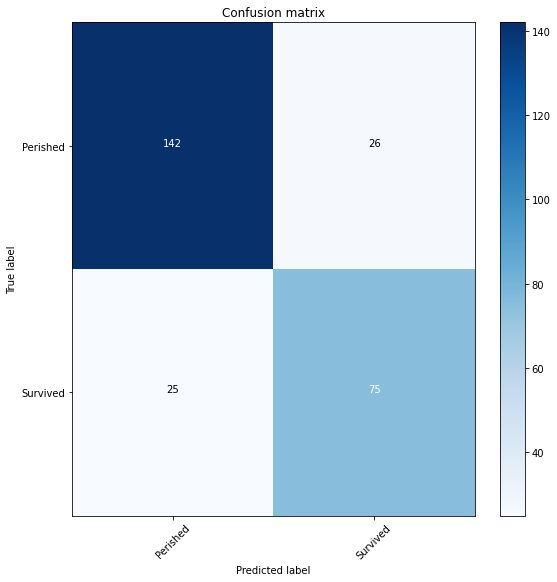

In [98]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

clf_gbc = GradientBoostingClassifier(loss='deviance',
                                     learning_rate=0.1,
                                     n_estimators=200,
                                     subsample=1.0, 
                                     min_samples_split=3, 
                                     min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, 
                                     max_depth=3, 
                                     init=None, 
                                     random_state=0, 
                                     max_features=None, 
                                     verbose=0, 
                                     max_leaf_nodes=None, 
                                     warm_start=False,).fit(X_train, y_train)

roc_gbc = clf_eval(clf_gbc, X_test, y_test)

#### XGBoost:

https://github.com/dmlc/xgboost/tree/master/python-package  
https://xgboost.readthedocs.io/en/latest/build.html#building-on-ubuntu-debian  
http://xgboost.readthedocs.io/en/latest/build.html#python-package-installation  
http://xgboost.readthedocs.io/en/latest/parameter.html  
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/  
https://www.kaggle.com/cbrogan/titanic/xgboost-example-python/run/1620  
http://xgboost.readthedocs.io/en/latest//python/python_api.html#module-xgboost.sklearn  

XGBoost is one of the most popular and widely used algorithms today because it is simply so powerful.

+ It is similar to Gradient Boost but has a few extra features that make it that much stronger.
+ Newton Boosting — Provides a direct route to the minima than gradient descent, making it much faster.
+ An extra randomization parameter — reduces the correlation between trees, ultimately improving the strength of the ensemble.

[19:34:19] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classification Report
              precision    recall  f1-score   support

    Perished       0.85      0.90      0.87       168
    Survived       0.81      0.73      0.77       100

    accuracy                           0.84       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.83      0.84      0.83       268

ROC Score: 0.8144047619047619
Accuracy Score: 0.835820895522388
Average Precision Score: 0.6928573797678276
f1 Score: 0.768421052631579
Confusion matrix, without normalization
[[151  17]
 [ 27  73]]
CPU times: user 4min 38s, sys: 968 ms, total: 4min 39s
Wall time: 1min 12s


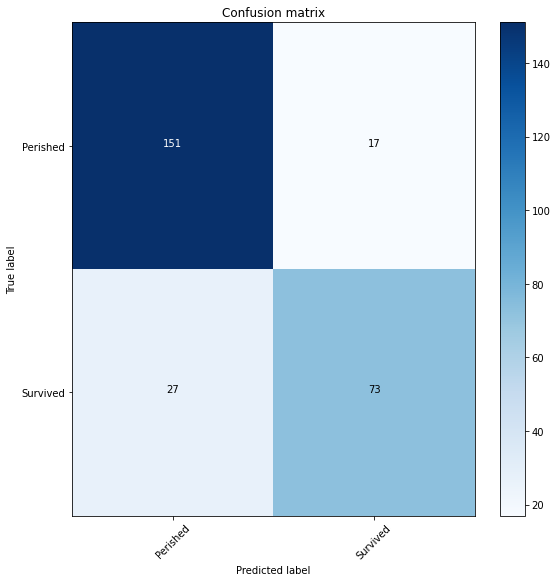

In [99]:
%%time

import xgboost

clf_xgb = xgboost.sklearn.XGBClassifier(base_score=0.5,
                                        learning_rate=0.1,
                                        n_estimators=250,
                                        max_delta_step=0,
                                        max_depth=2,
                                        min_child_weight=1,
                                        missing=1,
                                        gamma=0.1,
                                        subsample=1,
                                        colsample_bylevel=1,
                                        colsample_bytree=1,
                                        objective= 'binary:logitraw',
                                        #objective='multi:softprob',
                                        eval_metric='auc',
                                        #eval_metric='logloss',
                                        reg_alpha=0, 
                                        reg_lambda=1,
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=0,
                                        silent=False,
                                        use_label_encoder=False,
                                        random_state=0).fit(X_train, y_train)

roc_xgb = clf_eval(clf_xgb, X_test, y_test)

#### Light GBM: 

It is another type of boosting algorithm that has shown to be faster and sometimes more accurate than XGBoost.

+ It uses a unique technique called Gradient-based One-side sampling (GOSS) to filter out the data instances to find a split value.

Classification Report
              precision    recall  f1-score   support

    Perished       0.85      0.85      0.85       168
    Survived       0.75      0.75      0.75       100

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

ROC Score: 0.800595238095238
Accuracy Score: 0.8134328358208955
Average Precision Score: 0.6557835820895522
f1 Score: 0.75
Confusion matrix, without normalization
[[143  25]
 [ 25  75]]
CPU times: user 13min 14s, sys: 3.19 s, total: 13min 17s
Wall time: 3min 17s


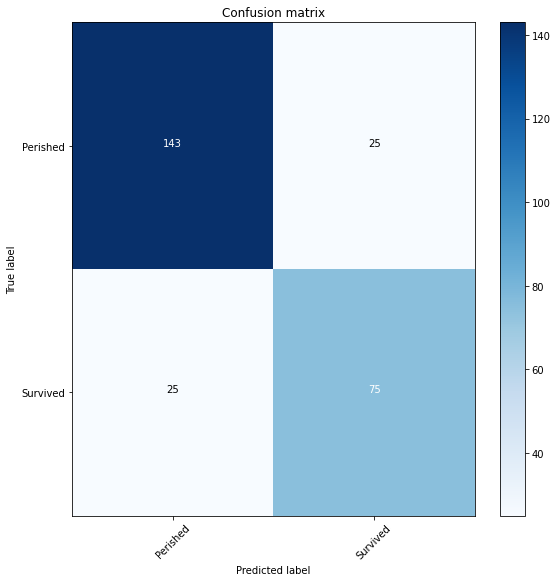

In [100]:
%%time

import lightgbm as lgb

params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'num_leaves': 64, 
          'learning_rate': 0.05, 
          'max_bin': 512, 
          'subsample_for_bin': 200,
          'subsample': 1, 
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 5, 
          'reg_lambda': 10,
          'min_split_gain': 0.15, 
          'min_child_weight': 1, 
          'min_child_samples': 5, 
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

clf_lgb = lgb.LGBMClassifier(boosting_type= 'gbdt',
                             objective = 'binary',
                             n_jobs = -1,
                             silent = True,
                             max_depth = params['max_depth'],
                             max_bin = params['max_bin'],
                             subsample_for_bin = params['subsample_for_bin'],
                             subsample = params['subsample'],
                             subsample_freq = params['subsample_freq'],
                             min_split_gain = params['min_split_gain'], 
                             min_child_weight = params['min_child_weight'], 
                             min_child_samples = params['min_child_samples'], 
                             scale_pos_weight = params['scale_pos_weight'])

clf_lgb.fit(X_train, y_train)


roc_lgb = clf_eval(clf_lgb, X_test, y_test)

#### Regularized Greedy Forest

https://www.analyticsvidhya.com/blog/2018/02/introductory-guide-regularized-greedy-forests-rgf-python/  
https://github.com/fukatani/rgf_python  
https://github.com/MLWave/RGF-sklearn -- another implementation  
https://github.com/RGF-team/rgf_python -- another implementation  


In Boosting algorithms, each classifier/regressor is trained on data, taking into account the previous classifiers’/regressors’ success. After each training step, the weights are redistributed. Mis-classified data increases its weights to emphasize the most difficult cases. In this way, subsequent learners will focus on them during their training. However, the boosting methods simply treat the decision tree base learner as a black box and it does not take advantage of the tree structure itself.  In a sense, boosting does a partial corrective step to the model at each iteration. In contrast, RGF performs 2 steps:

+ Finds the one step structural change to the current forest to obtain the new forest that minimises the loss function (e.g. Least squares or logloss)
+ Adjusts the leaf weights for the entire forest to minimize the loss function

Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.85      0.85       168
    Survived       0.75      0.76      0.76       100

    accuracy                           0.82       268
   macro avg       0.80      0.81      0.80       268
weighted avg       0.82      0.82      0.82       268

ROC Score: 0.8055952380952381
Accuracy Score: 0.8171641791044776
Average Precision Score: 0.6614334269247821
f1 Score: 0.7562189054726369
Confusion matrix, without normalization
[[143  25]
 [ 24  76]]
CPU times: user 133 ms, sys: 171 ms, total: 304 ms
Wall time: 5.86 s


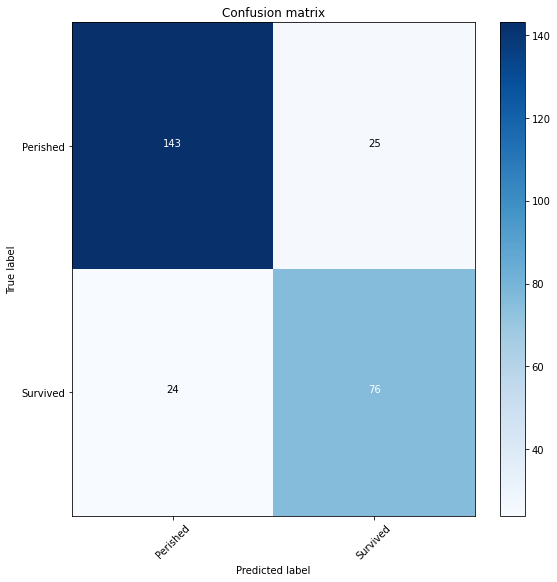

In [101]:
%%time

from rgf.sklearn import RGFClassifier, FastRGFClassifier

clf_rgf = RGFClassifier(max_leaf=100,
                        algorithm="RGF_Sib",
                        test_interval=60,
                        verbose=False,).fit(X_train, y_train)

roc_rgf = clf_eval(clf_rgf, X_test, y_test)

### [Bayesian Classifiers](http://scikit-learn.org/stable/modules/naive_bayes.html)  

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html  
http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html  

Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

+ As the name specifies, this algorithm is entirely based on Bayes's theorem. Bayes’ theorem says we can calculate the probability of a piece of data belonging to a given class if prior knowledge is given.  
+ P(class|data) = (P(data|class) * P(class)) / P(data)

Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.70      0.78       168
    Survived       0.62      0.82      0.71       100

    accuracy                           0.75       268
   macro avg       0.74      0.76      0.74       268
weighted avg       0.78      0.75      0.75       268

ROC Score: 0.7611904761904761
Accuracy Score: 0.746268656716418
Average Precision Score: 0.576558118498417
f1 Score: 0.706896551724138
Confusion matrix, without normalization
[[118  50]
 [ 18  82]]
CPU times: user 106 ms, sys: 12 ms, total: 118 ms
Wall time: 127 ms


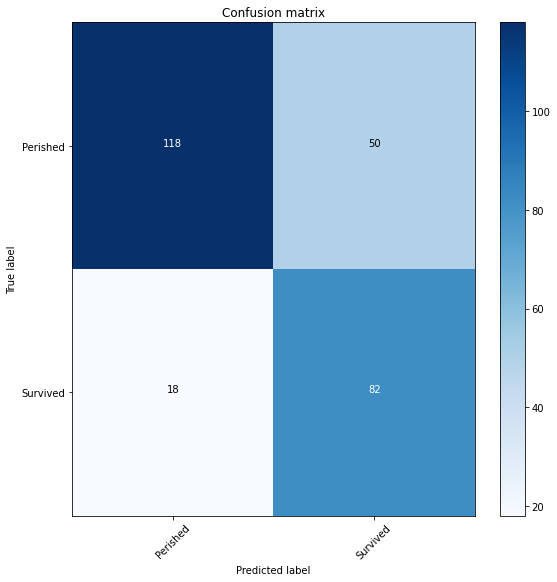

In [102]:
%%time

from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB().fit(X_train, y_train)

roc_gnb = clf_eval(clf_gnb, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

    Perished       0.83      0.73      0.78       168
    Survived       0.62      0.75      0.68       100

    accuracy                           0.74       268
   macro avg       0.73      0.74      0.73       268
weighted avg       0.75      0.74      0.74       268

ROC Score: 0.7410714285714286
Accuracy Score: 0.7388059701492538
Average Precision Score: 0.5620335820895522
f1 Score: 0.6818181818181818
Confusion matrix, without normalization
[[123  45]
 [ 25  75]]
CPU times: user 109 ms, sys: 7.91 ms, total: 116 ms
Wall time: 110 ms


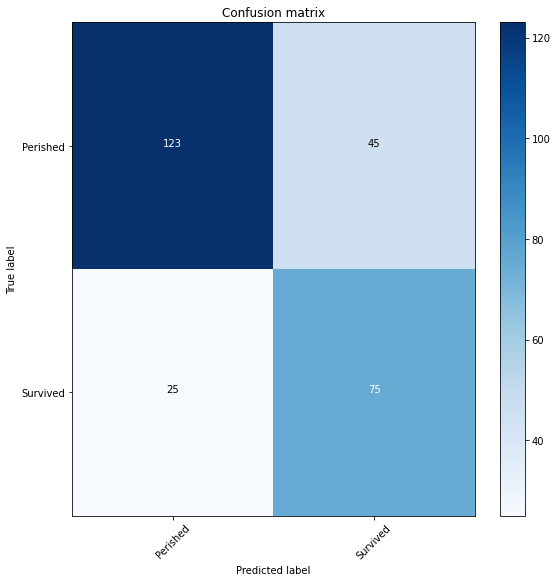

In [103]:
%%time

from sklearn.naive_bayes import BernoulliNB

clf_bnb = BernoulliNB(alpha=0.20, 
                     binarize=0.0, 
                     fit_prior=True, 
                     class_prior=None).fit(X_train, y_train)

roc_bnb = clf_eval(clf_bnb, X_test, y_test)

### Gaussian Processes

In the simple linear regression setting, we have a dependent variable y that we assume can be modeled as a function of an independent variable x, i.e. y=f(x)+ϵ (where ϵ is the irreducible error) but we assume further that the function f defines a linear relationship and so we are trying to find the parameters θ0  and θ1 which define the intercept and slope of the line respectively, i.e. y=θ0+θ1x+ϵ. Bayesian linear regression provides a probabilistic approach to this by finding a distribution over the parameters that gets updated whenever new data points are observed. The GP approach, in contrast, is a non-parametric approach, in that it finds a distribution over the possible functions f(x) that are consistent with the observed data. As with all Bayesian methods it begins with a prior distribution and updates this as data points are observed, producing the posterior distribution over functions.

Classification Report
              precision    recall  f1-score   support

    Perished       0.85      0.83      0.84       168
    Survived       0.72      0.76      0.74       100

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

ROC Score: 0.7936904761904762
Accuracy Score: 0.8022388059701493
Average Precision Score: 0.6396474769012083
f1 Score: 0.7414634146341463
Confusion matrix, without normalization
[[139  29]
 [ 24  76]]
CPU times: user 3.3 s, sys: 3.08 s, total: 6.37 s
Wall time: 1.8 s


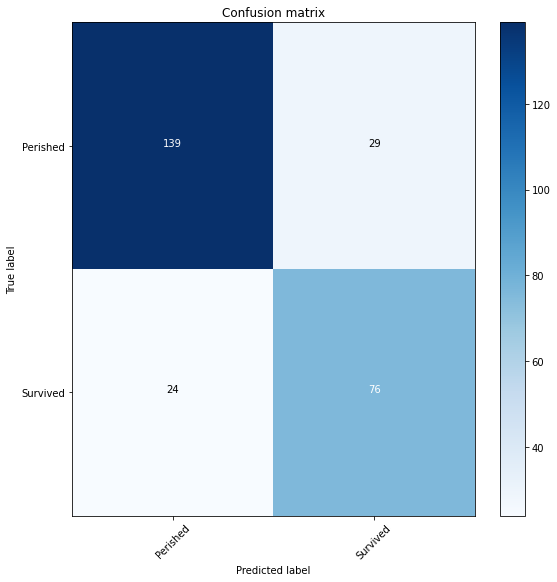

In [104]:
%%time

from sklearn.gaussian_process import GaussianProcessClassifier

clf_gpc = GaussianProcessClassifier(kernel=None, 
                                    optimizer='fmin_l_bfgs_b', 
                                    n_restarts_optimizer=0, 
                                    max_iter_predict=100, 
                                    warm_start=False, 
                                    copy_X_train=True, 
                                    random_state=0, 
                                    multi_class='one_vs_rest', 
                                    n_jobs=-1).fit(X_train, y_train)

roc_gpc = clf_eval(clf_gpc, X_test, y_test)

### Neural Networks

#### Tensorflow and Keras

762 train samples
268 test samples


2021-10-14 19:38:56.939174: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-14 19:38:56.939452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 19:38:56.940133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.90GiB deviceMemoryBandwidth: 510.07GiB/s
2021-10-14 19:38:56.940237: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-14 19:38:56.940280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-14 19:38:56.940305: I tensorflow/stream_executor/platform/default/dso_l

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1300      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                2

2021-10-14 19:38:57.897900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-14 19:38:57.966451: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2021-10-14 19:38:59.140092: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-14 19:39:05.108968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


Test loss: 0.6096789836883545
Test accuracy: 0.746268630027771
Classification Report
              precision    recall  f1-score   support

    Perished       0.92      0.65      0.76       168
    Survived       0.61      0.90      0.73       100

    accuracy                           0.75       268
   macro avg       0.76      0.78      0.74       268
weighted avg       0.80      0.75      0.75       268

ROC Score: 0.7773809523809524
Accuracy Score: 0.746268656716418
Average Precision Score: 0.5846107301331183
f1 Score: 0.7258064516129032
Confusion matrix, without normalization
[[110  58]
 [ 10  90]]
CPU times: user 4.41 s, sys: 496 ms, total: 4.91 s
Wall time: 11.9 s


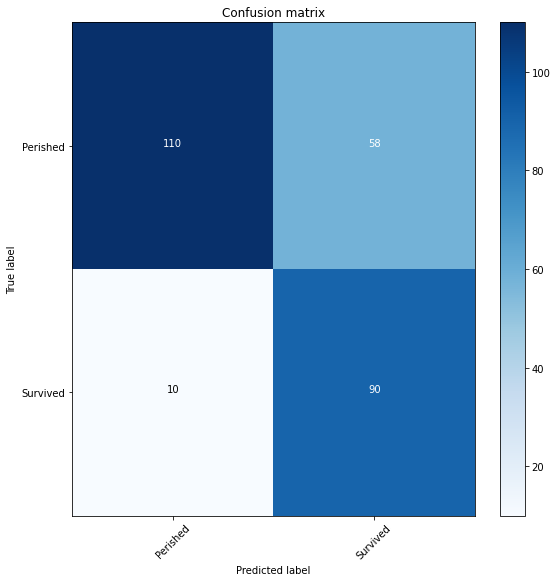

In [105]:
%%time

import tensorflow as tf

X_train_kr = X_train.astype('float32') 
X_test_kr = X_test.astype('float32')
y_train_kr = y_train
y_test_kr = y_test

print(X_train_kr.shape[0], 'train samples')
print(X_test_kr.shape[0], 'test samples')



batch_size = int(len(X_train_kr)/25)
num_classes = 2
epochs = 11
np.random.seed(0)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(input_dim=X_train_kr.shape[1], units=100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=24, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) #kernel_initializer='uniform',
model.summary()

#opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.01, epsilon=1e-07, centered=False, name='RMSprop')


model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['binary_accuracy'])

history = model.fit(X_train_kr, y_train_kr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    shuffle=False,
                    validation_data=(X_test_kr, y_test_kr))

score = model.evaluate(X_test_kr, y_test_kr, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#WARNING:tensorflow:From <timed exec>:50: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated 
# and will be removed after 2021-01-01. Instructions for updating:
# Please use instead: `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   
#(e.g. if it uses a `softmax` last-layer activation).
#`(model.predict(x) > 0.5).astype("int32")`, if your model does binary classification (e.g. if it uses a `sigmoid` last-layer activation).

#y_pred = model.predict_classes(X_test_kr) 
y_pred = (model.predict(X_test_kr) > 0.5).astype("int32")

clf_matrix = confusion_matrix(y_test_kr, y_pred)
print('Classification Report')
print(classification_report(y_test_kr, y_pred, target_names=['Perished', 'Survived']))
print('ROC Score: {}'.format(roc_auc_score(y_test_kr, y_pred)))
print('Accuracy Score: {}'.format(accuracy_score(y_test_kr, y_pred)))
print('Average Precision Score: {}'.format(average_precision_score(y_test_kr, y_pred)))
print('f1 Score: {}'.format(f1_score(y_test_kr, y_pred)))
plot_confusion_matrix(clf_matrix, classes=['Perished', 'Survived'])
roc_keras = roc_auc_score(y_test_kr, y_pred)

In [106]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


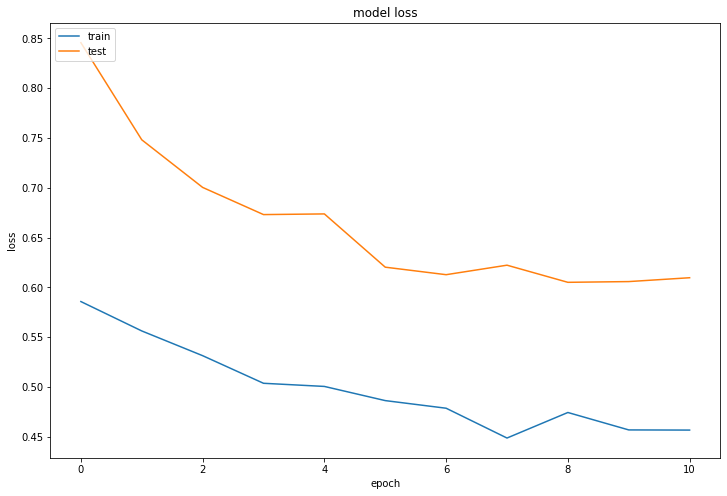

In [107]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

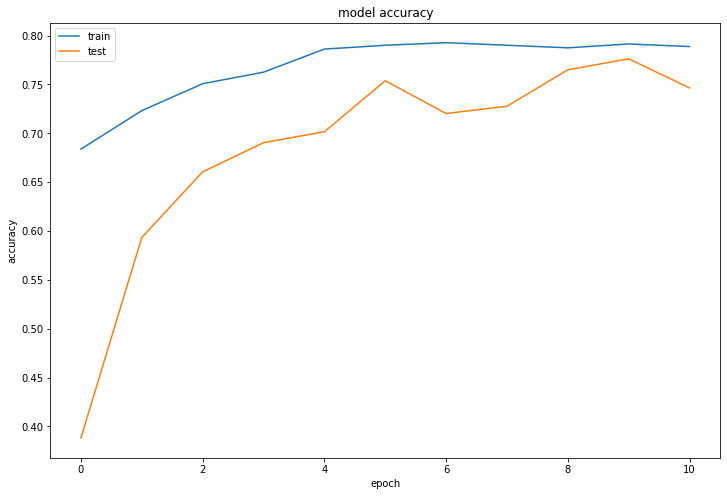

In [108]:
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Genetic Algorithms / AutoML

https://github.com/rhiever/tpot  
https://github.com/rhiever/tpot/blob/master/tutorials/Titanic_Kaggle.ipynb


60.09 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: XGBClassifier(ExtraTreesClassifier(GaussianNB(XGBClassifier(input_matrix, learning_rate=1.0, max_depth=7, min_child_weight=12, n_estimators=100, n_jobs=1, subsample=0.9500000000000001, verbosity=0)), bootstrap=True, criterion=gini, max_features=0.15000000000000002, min_samples_leaf=10, min_samples_split=20, n_estimators=100), learning_rate=1.0, max_depth=2, min_child_weight=16, n_estimators=100, n_jobs=1, subsample=0.9500000000000001, verbosity=0)
Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.88      0.87       168
    Survived       0.79      0.78      0.78       100

    accuracy                           0.84       268
   macro avg       0.83      0.83      0.83       268
weighted avg       0.84      0.84      0.84       268

ROC Score: 0.8275
Acc

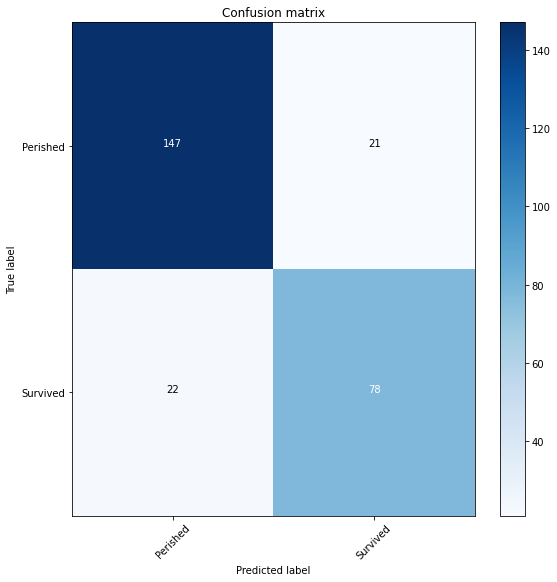

In [109]:
%%time

from tpot import TPOTClassifier

clf_tpot = TPOTClassifier(verbosity=1, 
                          max_time_mins=60, 
                          max_eval_time_mins=10, 
                          population_size=100,
                          generations=100,
                          n_jobs=-1)

clf_tpot.fit(X_train, y_train)
roc_tpot = clf_eval(clf_tpot, X_test, y_test)

#clf_tpot.export('tpot_exported_pipeline.py')

In [110]:
# %load tpot_exported_pipeline.py

### [Voting / Stacking](http://scikit-learn.org/stable/modules/ensemble.html#votingclassifier)  

[article](https://medium.com/@satyam-kumar/use-voting-classifier-to-improve-the-performance-of-your-ml-model-805345f9de0e)  

Voting algorithms are simple strategies, where you aglomerate results of classifiers' decisions by for example taking the class which appears in most cases. 

Stacking/grading strategies are generalizations of this concept. Instead of simply saying "ok, I have a scheme v, which I will use to select the best answer among my k classifiers" you create another abstraction layer, where you actually learn to predict the correct label having k votes.  

Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.86      0.87       168
    Survived       0.77      0.79      0.78       100

    accuracy                           0.84       268
   macro avg       0.82      0.83      0.83       268
weighted avg       0.84      0.84      0.84       268

ROC Score: 0.8265476190476191
Accuracy Score: 0.835820895522388
Average Precision Score: 0.6902209540532631
f1 Score: 0.7821782178217823
Confusion matrix, without normalization
[[145  23]
 [ 21  79]]
CPU times: user 4min 30s, sys: 1.61 s, total: 4min 31s
Wall time: 1min 15s


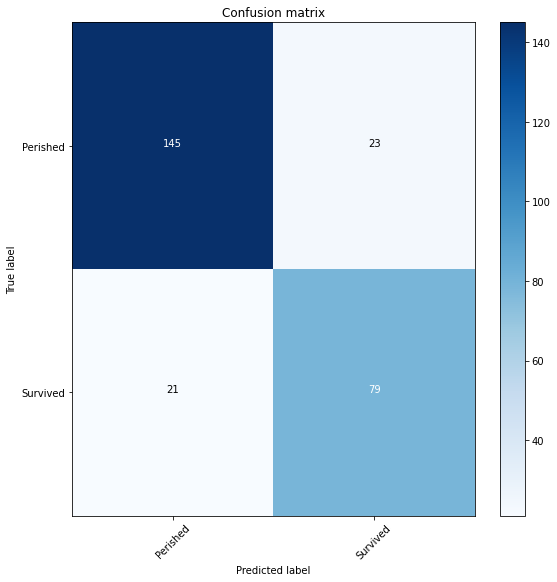

In [111]:
%%time

from sklearn.ensemble import VotingClassifier 

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    ensemble = VotingClassifier(estimators=[('clf_sgdc', clf_sgdc),
                                            ('clf_lgr', clf_lr),
                                            ('clf_rdg', clf_rgf),
                                            ('clf_bgc', clf_bgc),
                                            ('clf_etc', clf_etc),
                                            ('clf_abc', clf_abc),
                                            ('clf_pct', clf_pcp),
                                            ('clf_xgb', clf_xgb),
                                            ('clf_rf', clf_rf),
                                            ('clf_knn', clf_knn),
                                            ('clf_rgf', clf_rgf),
                                            #('clf_autoskl', clf_autoskl),
                                            #('clf_tpot', clf_tpot),
                                            ],
                                voting='hard',
                                weights=[1,1,1,1,1,1,1,2,1,2,1]).fit(X_train, y_train)

roc_ens = clf_eval(ensemble, X_test, y_test)

### Plotting the results:  

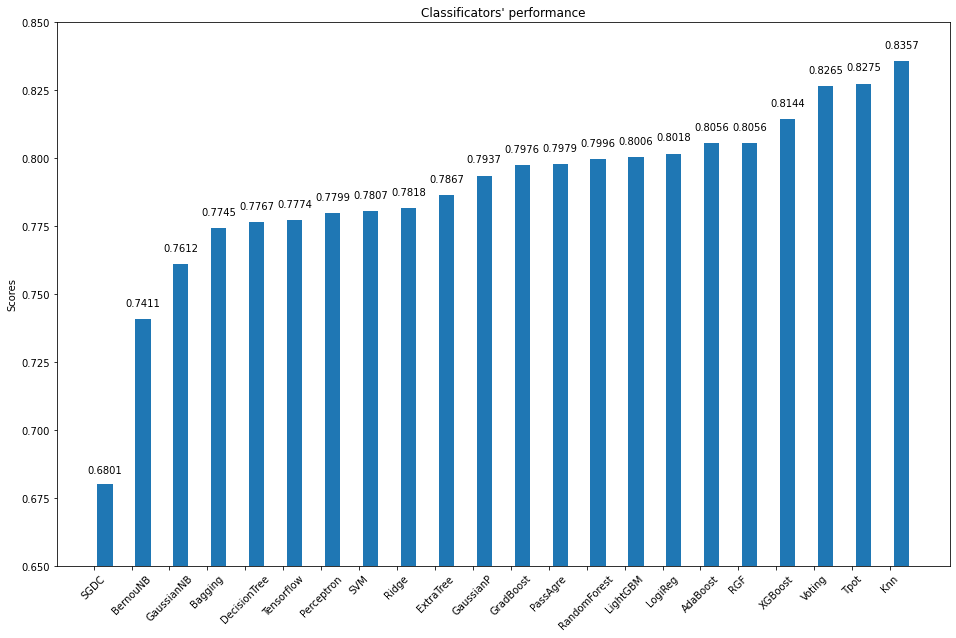

In [112]:
dic_results = {'SVM': roc_svc2,
               'RandomForest': roc_rf,
               'DecisionTree': roc_dtc,
               'ExtraTree': roc_etc,
               'AdaBoost': roc_abc,
               'GradBoost': roc_gbc,
               'LightGBM': roc_lgb,
               'SGDC': roc_sgdc,
               'Ridge': roc_rdg,
               'Perceptron': roc_pcp,
               'PassAgre': roc_pac,
               'LogiReg': roc_lr,
               'GaussianNB': roc_gnb,
               'BernouNB': roc_bnb,
               'RGF': roc_rgf,
               'XGBoost':roc_xgb,
               'Knn':roc_knn,
               'Tensorflow': roc_keras,
               'Bagging': roc_bgc,
               'Voting': roc_ens,
               'Tpot': roc_tpot,
               'RGF': roc_rgf,
               #'AutoSKL': roc_autoskl,
               'GaussianP': roc_gpc,
              }

import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Scores')
ax.set_ylim(ymin=0.65,ymax = 0.85)
ax.set_title("Classificators' performance")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=45)

plt.show()

In [113]:
features = df_train2.iloc[:,2:].columns
df_fi = pd.DataFrame({'clf_lr': (abs(clf_lr.coef_[0])/sum(abs(clf_lr.coef_[0]))),    #a sort of adaptation
                      'clf_rf':clf_rf.feature_importances_,
                      'clf_xgb':clf_xgb.feature_importances_,
                      'clf_etc':clf_etc.feature_importances_,
                      'clf_abc':clf_abc.feature_importances_,
                      'clf_bgc':clf_bgc.estimators_[0].feature_importances_,
                      'clf_gbc':clf_gbc.feature_importances_,
                      'clf_lgb':clf_lgb.feature_importances_ / sum(clf_lgb.feature_importances_),
                     },
                      index=features)
df_fi['mean_importance'] = df_fi.mean(axis=1)
df_fi.sort_values(['mean_importance'], ascending=False, inplace=True)
df_fi

,clf_lr,clf_rf,clf_xgb,clf_etc,clf_abc,clf_bgc,clf_gbc,clf_lgb,mean_importance
Gender,0.360369,0.217454,0.465311,0.273149,0.120000,0.299821,0.369615,0.030080,0.266975
Age*Class,0.124969,0.188600,0.071764,0.150496,0.193333,0.211035,0.177916,0.288521,0.175829
Fare,0.010792,0.164210,0.032505,0.136713,0.170000,0.156571,0.136052,0.295887,0.137841
AgeFill,0.088624,0.148655,0.031952,0.130488,0.266667,0.125705,0.099788,0.189073,0.135119
Pclass,0.142083,0.060280,0.139194,0.083511,0.013333,0.015493,0.062450,0.017188,0.066692
SibSp,0.111067,0.043414,0.043037,0.047599,0.090000,0.083099,0.043559,0.048496,0.063784
FamilySize,0.067010,0.055298,0.101032,0.051759,0.053333,0.027009,0.051221,0.045427,0.056511
Deck,0.035224,0.061269,0.067690,0.062261,0.070000,0.033798,0.034223,0.051565,0.052004
Parch,0.017816,0.021004,0.019631,0.025932,0.003333,0.014008,0.007409,0.004911,0.014255
Emb1,0.021256,0.014754,0.007202,0.015798,0.013333,0.016240,0.003624,0.018416,0.013828


Choosing the best classifier and training with all training data:

In [114]:
output = clf_rgf.predict(X_test)
print(output[10:20])
print()

output_prob = clf_rgf.predict_proba(X_test)
print(output_prob[10:20])

[0 1 0 1 1 1 0 0 0 1]

[[0.76063969 0.23936031]
 [0.24860446 0.75139554]
 [0.78120013 0.21879987]
 [0.09771839 0.90228161]
 [0.09245847 0.90754153]
 [0.30955202 0.69044798]
 [0.82284395 0.17715605]
 [0.51079669 0.48920331]
 [0.76109067 0.23890933]
 [0.43040223 0.56959777]]


#### Examining the ROC Curve

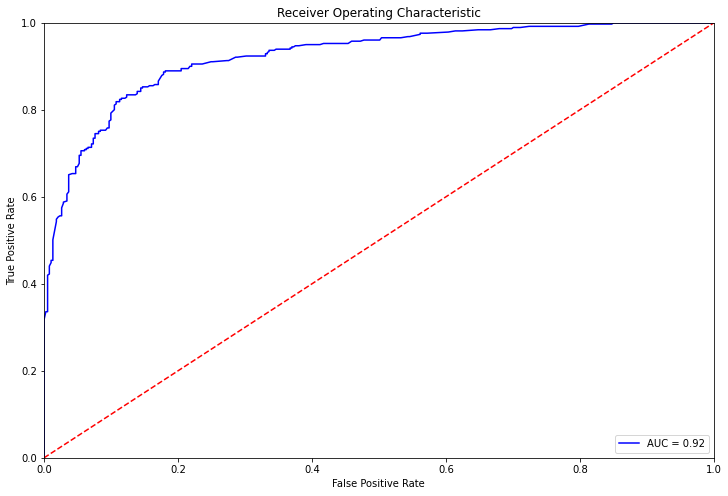

In [115]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_rgf.predict_proba(X_train)
y_hat = probs[:,1]
fpr, tpr, threshold = roc_curve(y_train, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()